# Homework 6

**Due: 03/27/2018** (Tuesday 27th March at 11:59pm).

## Instructions

+ In any case, develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:** Pratik
+ **Last Name:** Naik
+ **Email:** naik9@purdue.edu

## Readings

Before attempting the homework, it is probably a good idea to:
+ Review the slides of lectures 15, 16, 17 and 18; and
+ Review the corresponding lecture handouts.

In [51]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import design
import warnings
warnings.filterwarnings('ignore')
import orthpol  # This is the package we will use to construct orthogonal polynomials

In [52]:
#solver 
class Solver(object):
    def __init__(self, nt=100, T=5):
        """
        This is the initializer of the class.
        
        Arguments:
            nt - The number of timesteps.
            T  - The final time.
        """
        self.nt = nt
        self.T = T
        self.t = np.linspace(0, T, nt) # The timesteps on which we will get the solution
        # The following are not essential, but they are convenient
        self.num_input = 2             # The number of inputs the class accepts
        self.num_output = nt           # The number of outputs the class returns
        
    def __call__(self, x):
        """
        This special class method emulates a function call.
        
        Arguments:
            x - A 1D numpy array with 3 elements. This represents the stochastic input x = (x1, x2, x3).
        """
        ##uncertain quantities 
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
        
        #ODE parameters 
        omega = 2*np.pi + 0.1*x1 
        y10 = 1 + 0.1*x2
        y20 = 0.1*x3
        y0 = np.array([y10, y20])   #initial conditions 
        
        #coefficient matrix 
        zeta = 0.01
        k = omega**2    ##spring constant
        c = 2*zeta*omega   ##damping coeff. 
        C = np.array([[0, 1],[-k, -c]])
        
        #RHS of the ODE system
        def rhs(y, t):
            return np.dot(C, y)
        
        y = scipy.integrate.odeint(rhs, y0, self.t)
        
        return y

# Problem 1 

Consider the following stochastic harmonic oscillator:
$$
\begin{array}{ccc}
\ddot{y} + 2 \zeta \omega(X) \dot{y} + \omega^2(X)y &=& 0,\\
y(0) &=& y_0(X),\\
\dot{y}(0) &=& v_0(X),
\end{array}
$$
where $X = (X_1, X_2, X_3)$ and $X_i \sim \mathcal{N}(X_i|0, 1)$, 

$\omega(X) = 2\pi + X_1$, 

$\zeta = 0.01$ and 

$y_0(X) = 1+ 0.1 X_2$ and $v_0 = 0.1 X_3$.

A solver for this dynamical system is given in the previous cell. Our goal is to propagate uncertainty through this dynamical system, i.e. estimate the mean and variance of it's solution. We will do so, using the intrusive polynomial chaos (PC) approach and the non-instrusive stochastic collocation (SC) approach. 


### Part (a)

First, let us establish some ground truth. Generate 100000 samples of $X$  using Latin hypercube sampling. Compute the solution of the dynamical system corresponding to each sample of $X$. Estimate the mean and variance of the displacement, $y$ and velocity, $\dot{y}$ and visualize it. 

In [53]:
import design
num_lhs = 100000
X_lhs = design.latin_center(num_lhs, 3) # These are uniformly distributed - Turn them to standard normal
mu1=0.0
mu2=0.0
mu3=0.0
sigma1=1.0
sigma2=1.0
sigma3=1.0
mu = np.array([mu1, mu2,mu3])
Sigma = np.diag([sigma1 ** 2, sigma2 ** 2,sigma3 ** 2])
X_samples = mu + np.dot(st.norm.ppf(X_lhs), np.sqrt(Sigma))
solver = Solver(nt=100, T=5)
s = 0.
s2 = 0.
s_vel=0.
s_vel2=0.
for x in X_samples:
    y = solver(x)[:, 0]
    s += y
    s2 += y ** 2
    
    y_vel = solver(x)[:, 1]
    s_vel += y_vel
    s_vel2 += y_vel ** 2
    
    
y_mu_lhs = s / num_lhs
y_var_lhs = s2 / num_lhs - y_mu_lhs ** 2
y_vel_mu_lhs = s_vel / num_lhs
y_vel_var_lhs = s_vel2 / num_lhs - y_vel_mu_lhs ** 2

In [14]:
t = np.linspace(0,5,100)

In [54]:
np.save('y_var_lhs', y_var_lhs)
np.save('y_mu_lhs', y_mu_lhs) 

np.save('y_vel_var_lhs', y_vel_var_lhs)
np.save('y_vel_mu_lhs', y_vel_mu_lhs) 


In [ ]:
y_var_lhs=np.load('y_var_lhs.npy')
y_mu_lhs=np.load('y_mu_lhs.npy')
y_vel_var_lhs=np.load('y_vel_var_lhs.npy')
y_vel_mu_lhs=np.load('y_vel_mu_lhs.npy')

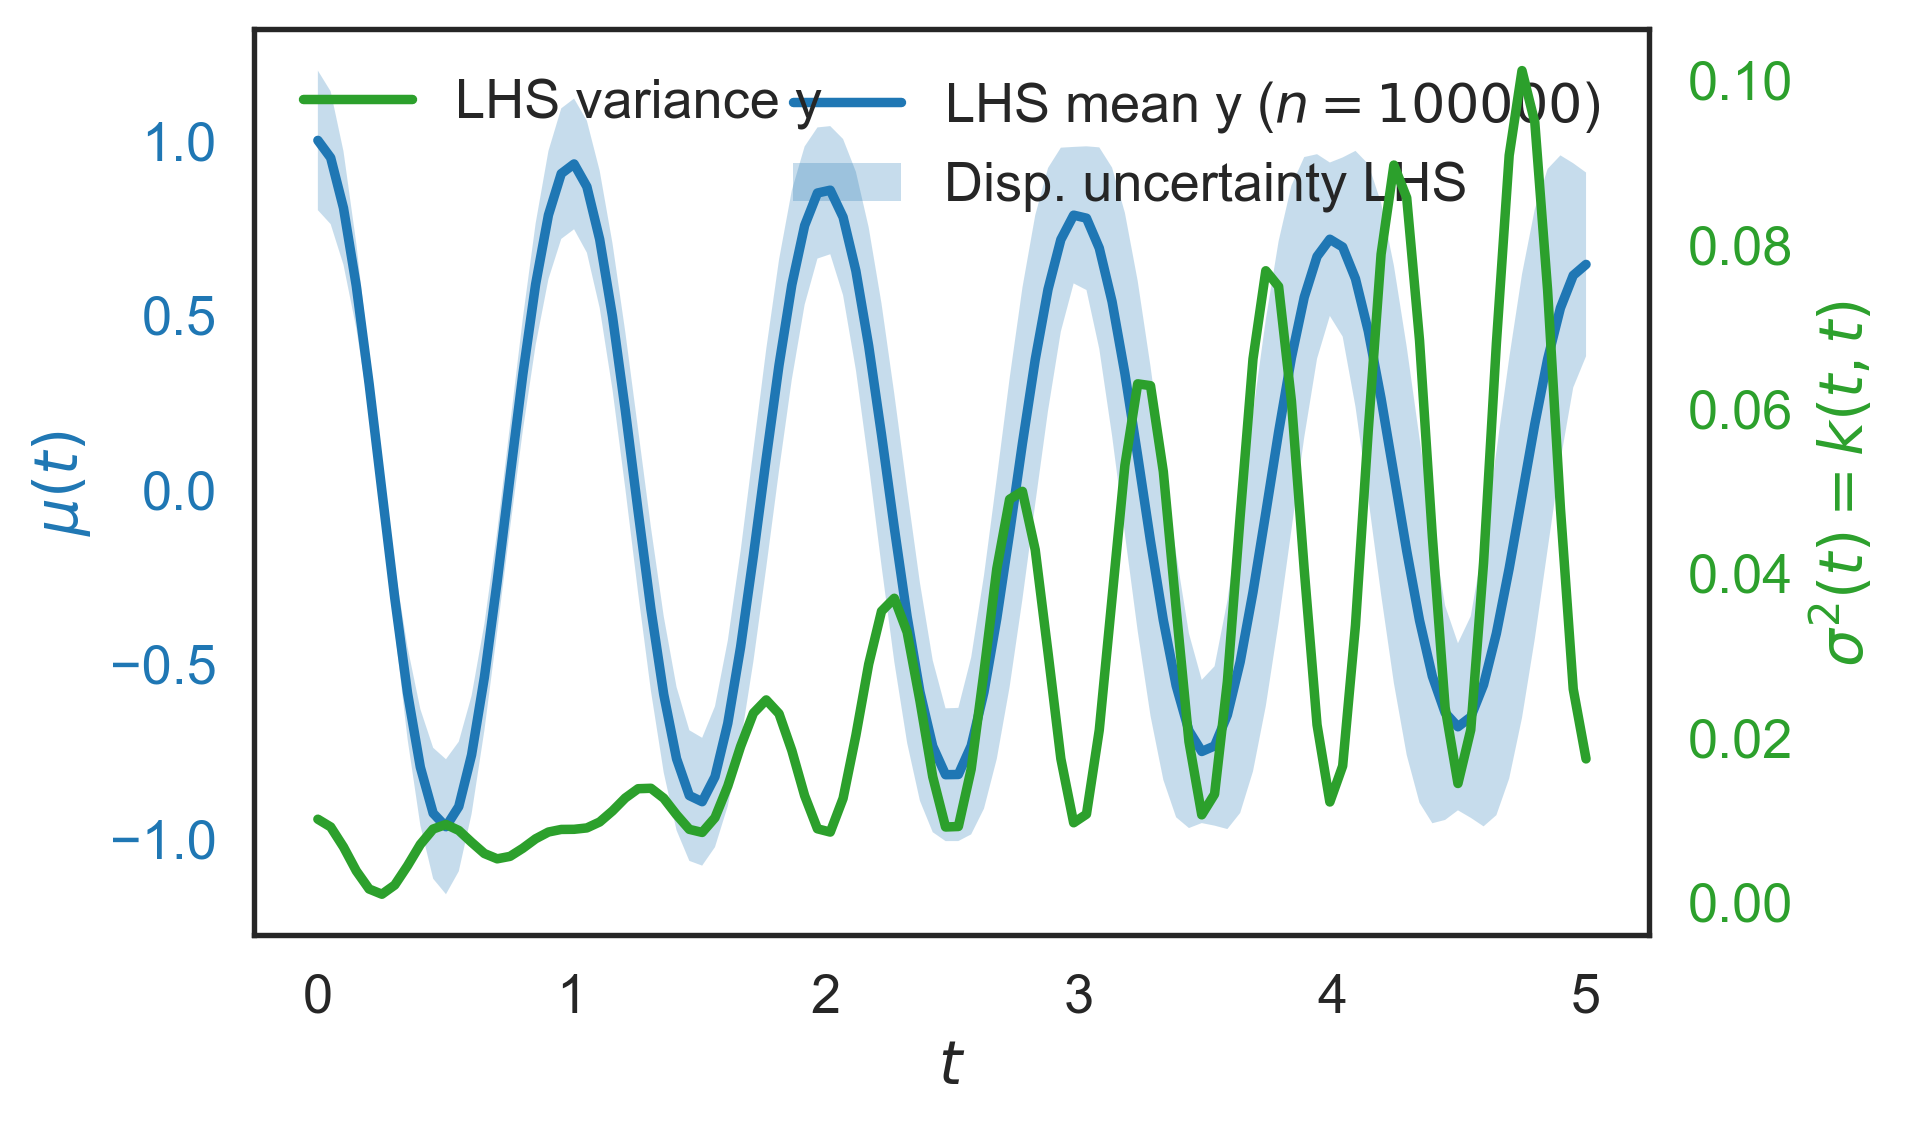

In [67]:
# Make the figure
fig1, ax1 = plt.subplots()
y_std_lhs=np.sqrt(y_var_lhs)
# Plot the mean and compare to LHS
ax1.plot(solver.t, y_mu_lhs, color=sns.color_palette()[0], label='LHS mean y ($n=%d$)' % num_lhs)
#ax1.plot(solver.t, y_vel_mu_lhs, color=sns.color_palette()[1], label='LHS mean y($n=%d$)' % num_lhs)
#ax1.plot(t, y_pc_m, '--', color=sns.color_palette()[1], label=r'PC mean ($\rho=%d$)' % degree)
plt.fill_between(solver.t, y_mu_lhs-2*y_std_lhs, y_mu_lhs+2*y_std_lhs, alpha=0.25, label = 'Disp. uncertainty LHS')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\mu(t)$', color=sns.color_palette()[0])
ax1.tick_params('y', colors=sns.color_palette()[0])
plt.legend(loc='best')

# Plot variance and compare to LHS
ax2 = ax1.twinx()
ax2.plot(solver.t, y_var_lhs, color=sns.color_palette()[2], label='LHS variance y')
#ax2.plot(solver.t, y_vel_var_lhs, color=sns.color_palette()[2], label='LHS variance y ($n=%d$)' % (num_lhs))
#ax2.plot(solver.t, y_pc_v, '--', color=sns.color_palette()[3], label=r'PC variance ($\rho=%d$)' % degree)
ax2.set_ylabel('$\sigma^2(t) = k(t, t)$', color=sns.color_palette()[2])
ax2.tick_params('y', colors=sns.color_palette()[2])
plt.legend(loc='best');


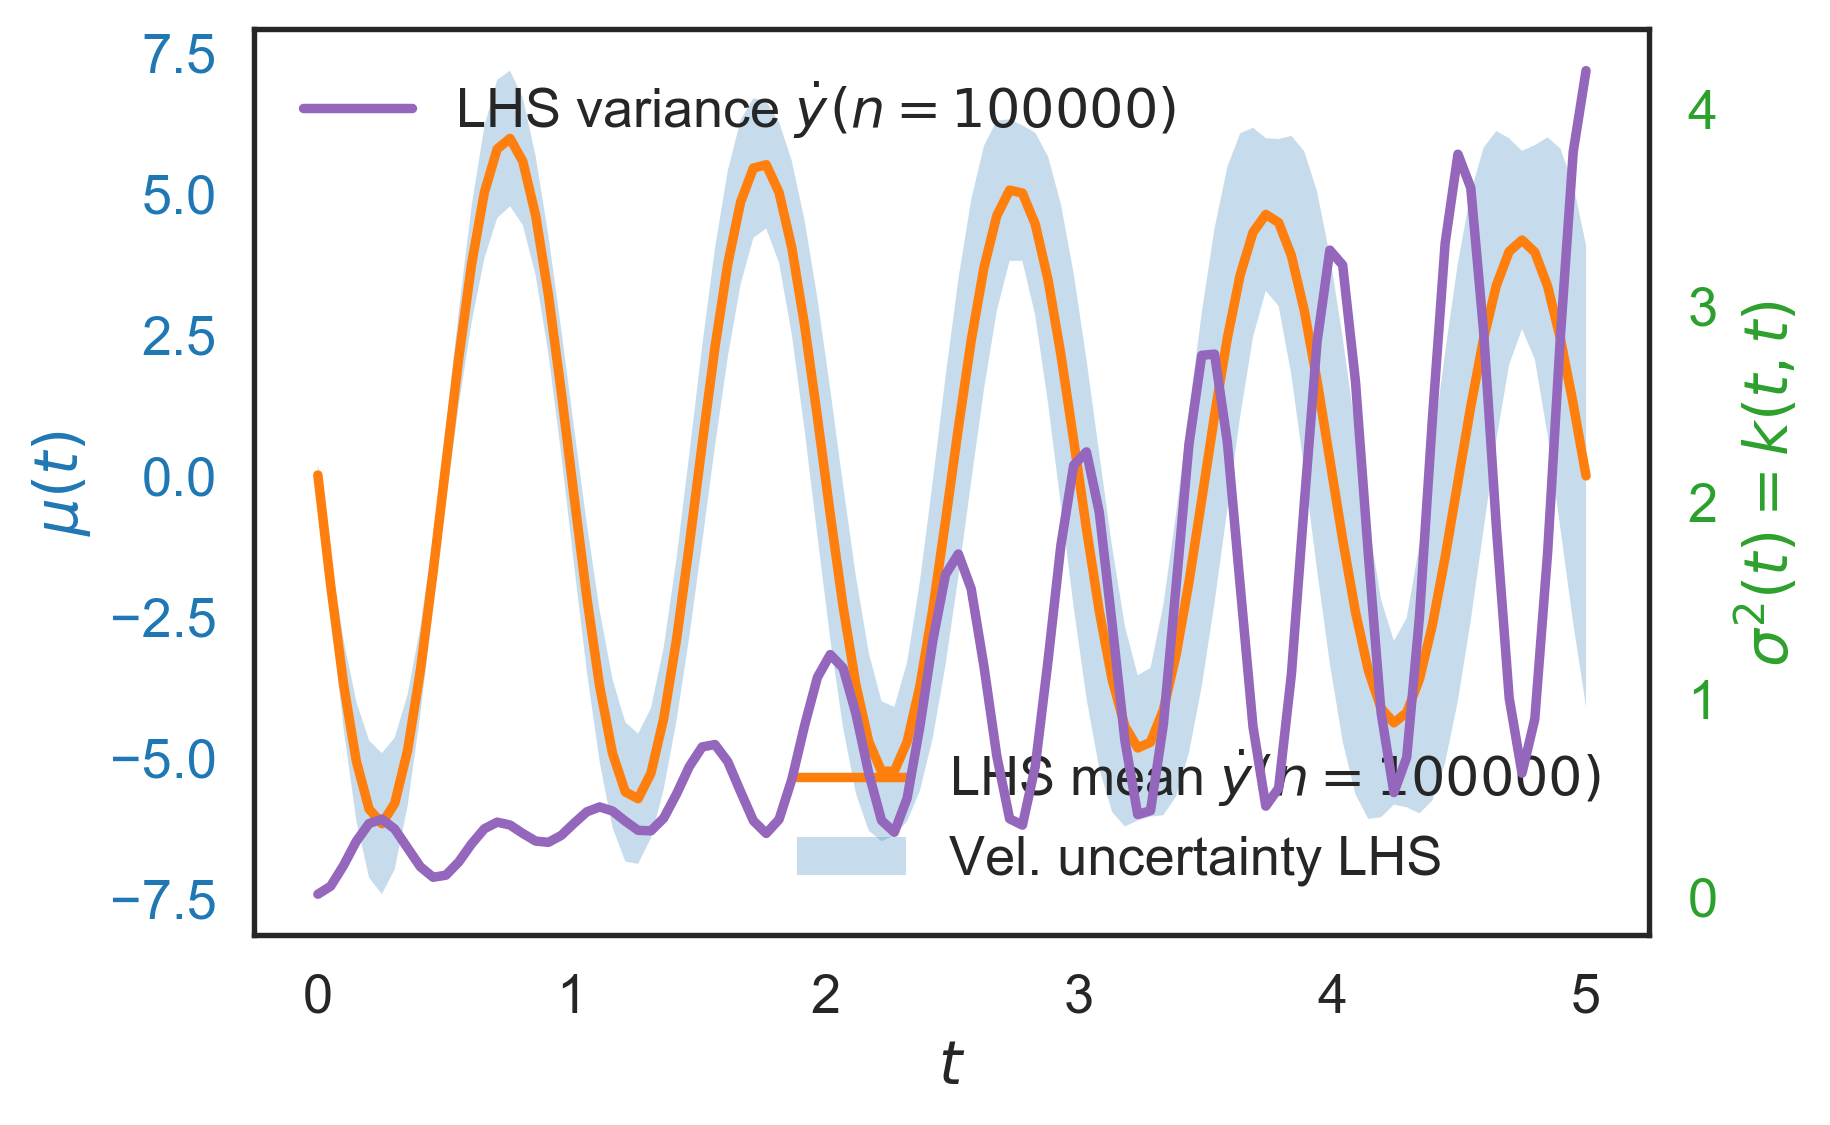

In [56]:
# Make the figure
fig2, ax3 = plt.subplots()
y_vel_std_lhs=np.sqrt(y_vel_var_lhs)
# Plot the mean and compare to LHS
ax3.plot(solver.t, y_vel_mu_lhs, color=sns.color_palette()[1], label='LHS mean $\dot y (n=%d)$' % num_lhs)
plt.fill_between(solver.t, y_vel_mu_lhs-2*y_vel_std_lhs, y_vel_mu_lhs+2*y_vel_std_lhs, alpha=0.25, label = 'Vel. uncertainty LHS')
#ax1.plot(t, y_vel_pc_m, '--', color=sns.color_palette()[1], label=r'PC mean ($\rho=%d$)' % degree)
ax3.set_xlabel('$t$')
ax3.set_ylabel('$\mu(t)$', color=sns.color_palette()[0])
ax3.tick_params('y', colors=sns.color_palette()[0])
plt.legend(loc='best')

# Plot variance and compare to LHS
ax4 = ax3.twinx()
ax4.plot(solver.t, y_vel_var_lhs, color=sns.color_palette()[4], label='LHS variance $\dot y (n=%d)$' % (num_lhs))
#ax2.plot(solver.t, y_vel_pc_v, '--', color=sns.color_palette()[3], label=r'PC variance ($\rho=%d$)' % degree)
ax4.set_ylabel('$\sigma^2(t) = k(t, t)$', color=sns.color_palette()[2])
ax4.tick_params('y', colors=sns.color_palette()[2])
plt.legend(loc='best');

### Part (b) - Intrusive uncertainty propagation using polynomial chaos

Recall that the general procedure for propagating uncertainties using polynomial chaos is as follows:
1. Expand quantities dependant on the uncertain parameters in a basis of polynomials, orthonormal w.r.t. the joint density of the uncertain parameters. 

2. Perform a Galerkin projection of the expanded quantities onto each orthonormal polynomial basis. This results in a system of ODEs for the PCE coefficients. 

3. Solve the system of equations for the PCE coefficients. The mean and variance of the independant variable in the original dynamical system, $u$, are obtained in closed form ($\mathbb{E}[u] = c_{1}(t)$ and $\mathbb{V}[u] = \sum_{i=2}^{n}c_{i}(t)^2$). 

The lecture handout contains two examples of UP using PCE - a 1st order ODE with uncertainties and an undamped stochastic harmonic oscillator (2nd order ODE). 

We now consider the case of the stochastic harmonic oscillator with damping.  

1 - Convert the given 2nd order DE into a system of 1st order ODEs and expand the uncertain quantities in a basis of orthogonal polynomials. Recover the dynamical system governing the coefficients of the PCE.

## Solution:

First, let's bring this to the form of a first order dynamical system.
We set:
$$
y_1 = y,
$$
and 
$$
y_2 = \dot{y}.
$$

The dynamical system becomes:
$$
\begin{array}{ccc}
\dot{y}_1 &=& y_2,\\
\dot{y}_2 &=& -\omega^2(X) y_1-2\zeta \omega(X) y_2,\\
y_1(0) &=& y_0(X),\\
y_2(0) &=& v_0(X).
\end{array}
$$

Now, let $\phi_1(x), \phi_2(x),\dots,\phi_n(x)$ be the orthonormal polynomials of $p(x)$, i.e.
$$
\langle \phi_i, \phi_j \rangle = \int \phi_i(x) \phi_j(x) p(x) dx = \delta_{ij}.
$$
Expand the solution of the dynamical system in these polynomials:
$$
\begin{array}{ccc}
y_1(t;x) &=& \sum_{i=1}^n c_{1i}(t) \phi_i(x),\\
y_2(t;x) &=& \sum_{i=1}^n c_{2i}(t) \phi_i(x).
\end{array}
$$

We will derive the dynamical system that the $c_{ki}(t)$'s satisfy.

Expand also, $\omega(x), y_0(x)$ and $v_0(x)$:
$$
\begin{array}{ccc}
\omega(x) &=& \sum_{i=1}^n \omega_i \phi_i(x),\\
y_0(x) &=& \sum_{i=1}^n y_{0i} \phi_i(x),\\
v_0(x) &=& \sum_{i=1}^n v_{0i} \phi_i(x).
\end{array}
$$
These coefficients, can all be found with a sparse grid quadrature before we even start:
$$
\begin{array}{ccc}
\omega_i &=& \langle \omega, \phi_i\rangle \approx \sum_{k=1}^{n_q}w_k\omega(x_k)\phi_i(x_k),\\
y_{0i} &=& \langle y_0, \phi_i\rangle \approx \sum_{k=1}^{n_q}w_k y_0(x_k)\phi_i(x_k),\\
v_{0i} &=& \langle v_0, \phi_i\rangle \approx \sum_{k=1}^{n_q}w_k v_0(x_k)\phi_i(x_k).
\end{array}
$$

Now back to the dynamical system.
We have:
$$
\dot{y}_1 = y_2 \Rightarrow \sum_{i=1}^n \dot{c}_{1i} \phi_i(x) = \sum_{i=1}^n c_{2i}\phi_i(x) \Rightarrow \dot{c}_{1i} = c_{2i},
$$
and
$$
\dot{y}_2 = -\omega^2(x) y_1-2\zeta\omega(x) y_2 \Rightarrow \sum_{i=1}^n\dot{c}_{2i}\phi_i(x) = -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j}\phi_i(x)\phi_r(x)\phi_j(x) -2\zeta\sum_{i,j=1}^n \omega_i c_{2j}\phi_i(x)\phi_j(x). 
$$

Taking the inner product with the basis functions:
$$
\langle\sum_{i=1}^{n} \dot{c}_{2i}\phi_i(x),  \phi_k(x) \rangle = \langle -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j}\phi_i(x)\phi_r(x)\phi_j(x), \phi_k(x) \rangle -\langle 2\zeta\sum_{i,j=1}^n \omega_ic_{2j}\phi_i(x)\phi_j(x)\phi_k(x)\rangle. 
$$

$$
\implies \dot{c}_{2k}= -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j} \langle \phi_k(x), \phi_i(x)\phi_r(x)\phi_j(x)  \rangle  -2\zeta\sum_{i,j=1}^n \omega_i c_{2j}\langle \phi_k(x),\phi_i(x)\phi_j(x)\rangle. 
$$

Define, 
$$
H_{irjk} = \langle \phi_i(x)\phi_r(x)\phi_j(x),  \phi_k(x)  \rangle 
\approx \sum_{q=1}^{n_q} w_q \phi_i(x_q) \phi_r(x_q) \phi_j(x_q) \phi_k(x_q)
$$

$$
H_{ijk}^{2} = \langle \phi_i(x)\phi_j(x),  \phi_k(x)  \rangle 
\approx \sum_{q=1}^{n_q} w_q \phi_i(x_q) \phi_j(x_q) \phi_k(x_q)
$$

We get:
$$
\implies \dot{c}_{2k}= -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j} H_{irjk}-2\zeta\sum_{i,j=1}^n \omega_i c_{2j} H_{ijk}^{2}
$$

To wrap it up, the dynamical sytem we need to solve is:
$$
\begin{array}{ccc}
\dot{c}_{1k} &=& c_{2k},\\
\dot{c}_{2k} &=& -\sum_{i,j,r=1}^n \omega_i\omega_r c_{1j} H_{irjk}-2\zeta\sum_{i,j=1}^n \omega_i c_{2j} H_{ijk}^{2},\\
c_{1k}(0) &=& y_{0k},\\
c_{2k}(0) &=& v_{0k},
\end{array}
$$
for $k=1,\dots,n$.

2 - Define a function ```pc_up``` which takes as argument, the order of the polynomial basis, $\rho$. Pick an appropriate sparse grid quadrature rule and the maximum level of the quadrature rule. The function should return the mean and the variance of the displacement and the velocity of the harmonic oscillator. We suggest using the Clenshaw-Curtis or the Fejer 1 quadrature rule as discussed in the handout. 

In [57]:
def pc_up(rho=1,quad_level=3):
    
    X1 = st.norm()
    X2 = st.norm()
    X3 = st.norm()
    mu1 = 0.0; sigma1 = 1
    mu2 = 0.0; sigma2 = 1
    mu3 = 0.0; sigma3 = 1
    mu = np.array([mu1, mu2,mu3])
    Sigma = np.diag([sigma1 ** 2, sigma2 ** 2,sigma3 ** 2])

    X = (X1, X2, X3)
    dim = len(X)
    Phi_set = orthpol.ProductBasis(X, degree=rho)
    print Phi_set.num_output
    
    # Modeling of the natural frequency:
    omega = lambda x: 2. * np.pi + 0.1 * x[:, 0]
    # Initial position
    y0 = lambda x: np.ones((x.shape[0],)) + 0.1 * x[:, 1]
    # Initial velocity
    v0 = lambda x: np.zeros((x.shape[0],)) + 0.1 * x[:, 2]
    
    # Get a quadrature rule - we will talk about the quadrature rules in Lecture 17.
    sg_level = quad_level
    Zq, v = design.sparse_grid(dim, sg_level, 'GH') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
    #w = v / 2
    #sXq = st.norm.ppf(0.5 * (Zq + 1.))
    Xq = Zq * np.sqrt(2.)
    w = v / np.sqrt(np.pi ** dim)
    
    #Xq = np.ndarray(sXq.shape)
    #Xq[:, 0] = sXq[:, 0] * sigma1 + mu1
    #Xq[:, 1] = sXq[:, 1] * sigma2 + mu2
    #Xq[:, 2] = sXq[:, 2] * sigma3 + mu3
    
    phi_q = Phi_set(Xq)
    
    # Evaluatae all needed coefficients
    omegas = np.einsum('k,k,ki->i', w, omega(Xq), phi_q)
    y0s = np.einsum('k,k,ki->i', w, y0(Xq), phi_q)
    v0s = np.einsum('k,k,ki->i', w, v0(Xq), phi_q)
    
    H = np.einsum('q,qi,qj,qr,qk->irjk', w, phi_q, phi_q, phi_q, phi_q)
    H2 = np.einsum('q,qi,qj,qk->ijk', w, phi_q, phi_q, phi_q)
    
    # Define the dynamical system
    n = Phi_set.num_output  #num basis functions 
    zeta=0.01;
    def c_rhs(c, t):
        c1 = c[:n]
        c2 = c[n:]
        c1_rhs = c2
        c2_rhs = -np.einsum('i,r,j,irjk ->k', omegas, omegas, c1, H)-2*zeta*np.einsum('i,j,ijk ->k', omegas, c2, H2)
        return np.hstack([c1_rhs, c2_rhs])

    c0 = np.hstack([y0s, v0s])
    # Solve the system
    t = np.linspace(0,5, 100)   #get timesteps 
    c = scipy.integrate.odeint(c_rhs, c0, t)   #integrate 
    
    # Post proces the results
    # Coefficients for the position
    c1 = c[:, :n]
    # Coefficients for th velocity
    c2 = c[:, n:]
    # Mean position
    y1_m = c1[:, 0]
    # Mean velocity
    y2_m = c2[:, 0]
    # Variance of position
    y1_v = np.sum(c1[:, 1:] ** 2, axis=1)
    # Variance of velocity
    y2_v = np.sum(c2[:, 1:] ** 2, axis=1)

    return y1_m,y1_v,y2_m,y2_v

In [58]:
rho=4
quad_level=3
y1_m,y1_v,y2_m,y2_v=pc_up(rho,quad_level)
# Lower and upper prediction intervals
y1_s = np.sqrt(y1_v)
y1_l = y1_m - 2. * y1_s
y1_u = y1_m + 2. * y1_s
y2_s = np.sqrt(y2_v)
y2_l = y2_m - 2. * y2_s
y2_u = y2_m + 2. * y2_s

35


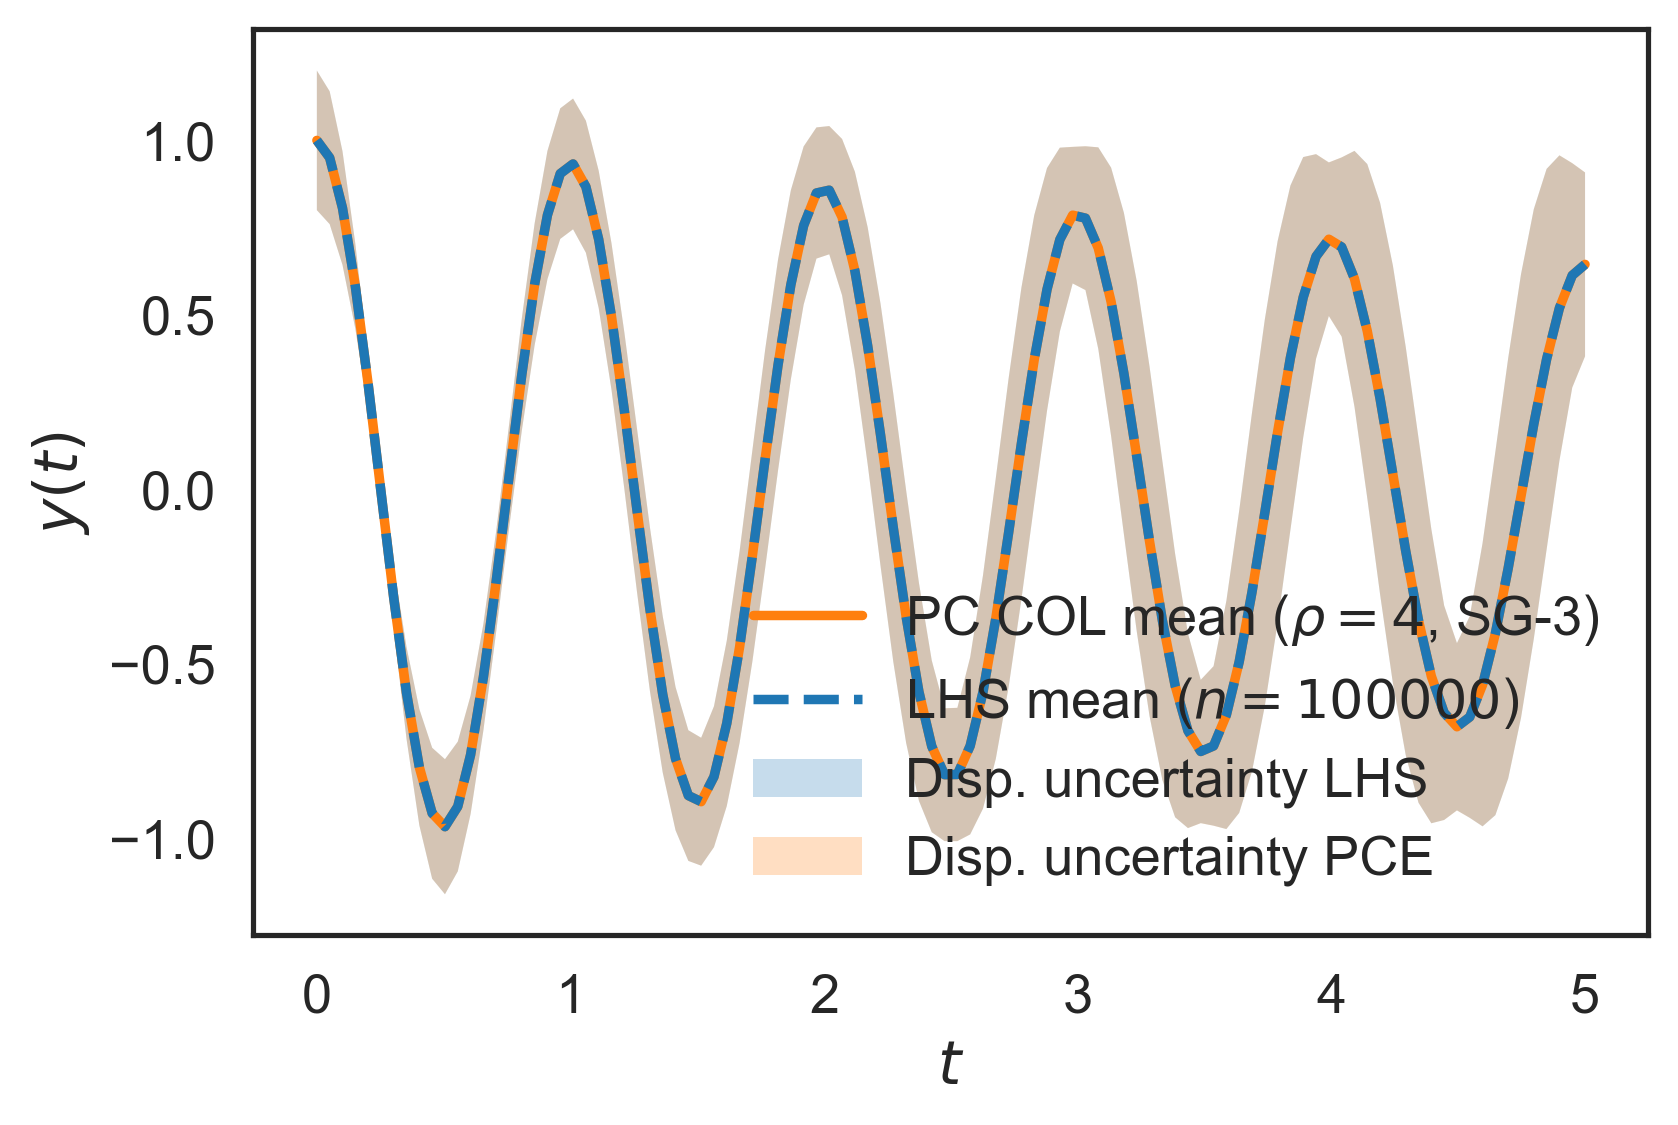

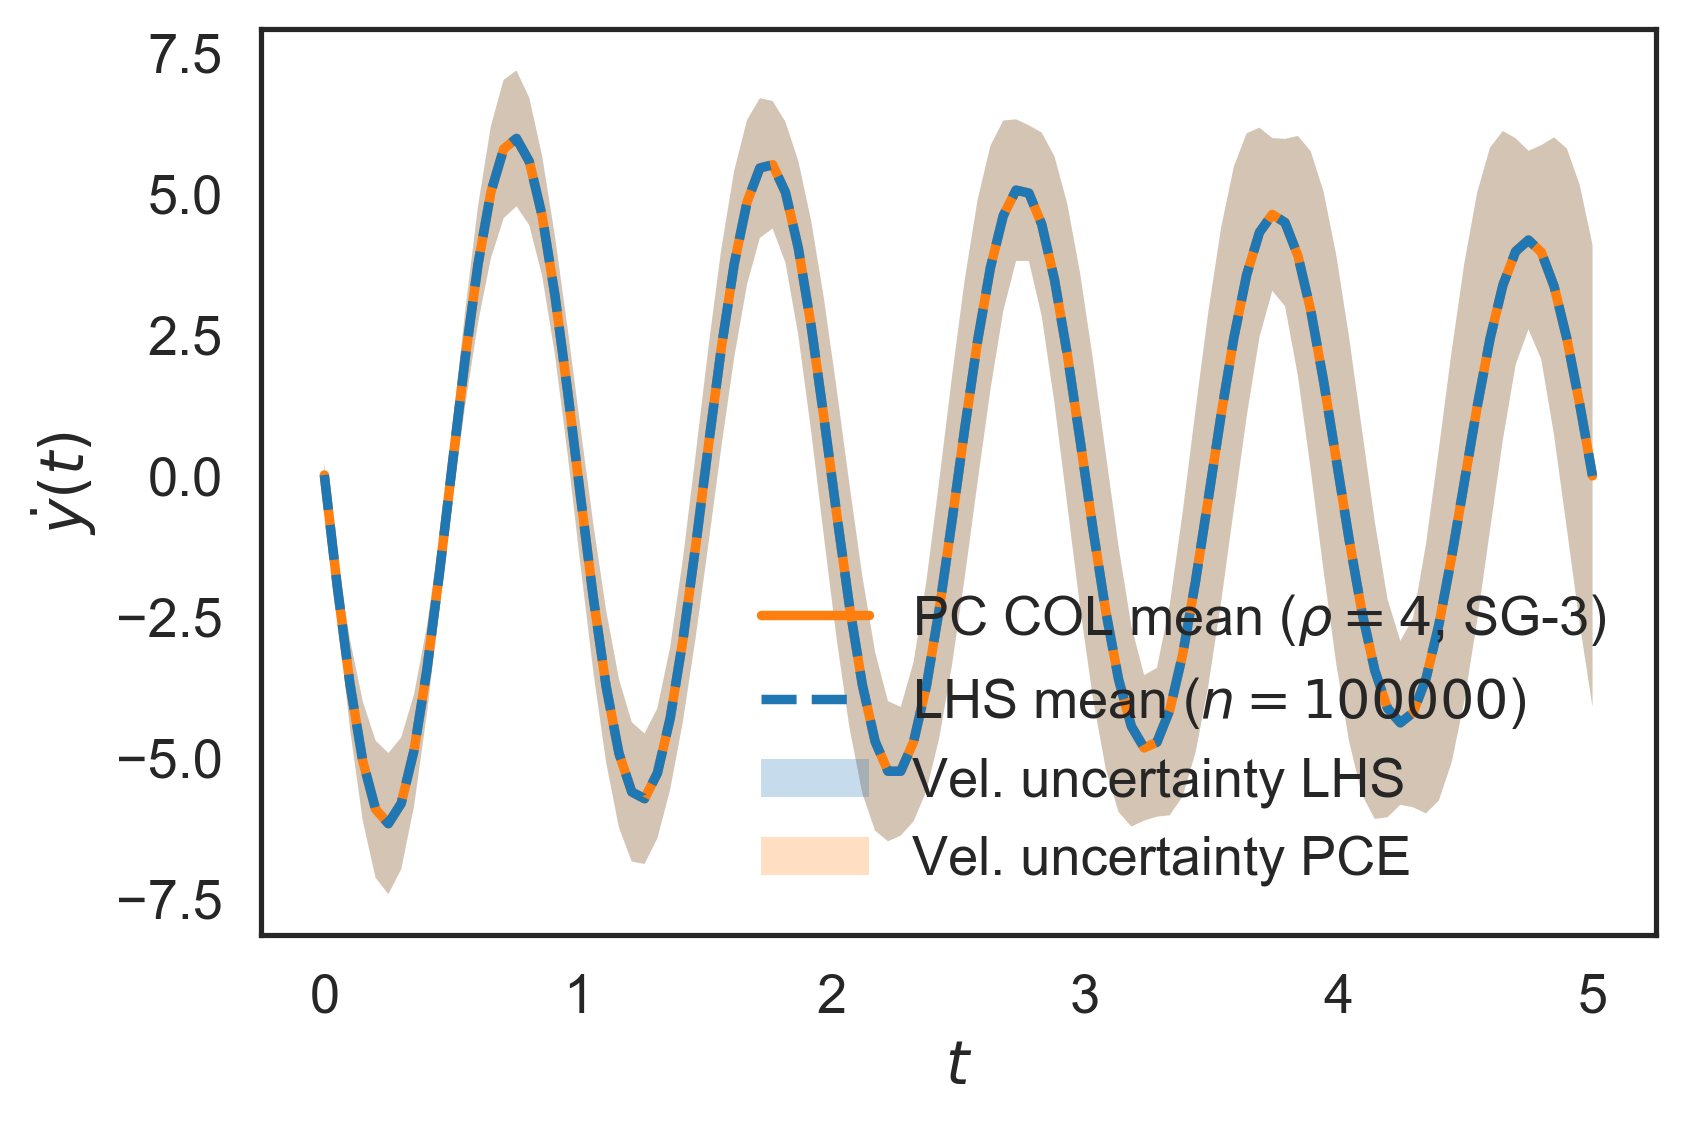

In [59]:
t = np.linspace(0,5,100)
y_std_lhs=np.sqrt(y_var_lhs)
y_vel_std_lhs=np.sqrt(y_vel_var_lhs)
fig, ax = plt.subplots()
ax.plot(t, y1_m,'-',color=sns.color_palette()[1],label=r'PC COL mean ($\rho=%d$, SG-%d)' % (rho, quad_level))
#ax.plot(t, y1_v,color=sns.color_palette()[2])
ax.plot(solver.t, y_mu_lhs,'--', color=sns.color_palette()[0], label='LHS mean ($n=%d$)' % num_lhs)
plt.fill_between(solver.t, y_mu_lhs-2*y_std_lhs, y_mu_lhs+2*y_std_lhs, alpha=0.25, label = 'Disp. uncertainty LHS')
plt.fill_between(t, y1_m-2*y1_s,y1_m+2*y1_s, alpha=0.25, label = 'Disp. uncertainty PCE')
plt.legend(loc='best')
#ax.fill_between(t, y1_l, y1_u, alpha=0.25)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$');
#plt.xlim([0,4])

fig, ax = plt.subplots()
ax.plot(t, y2_m,'-',color=sns.color_palette()[1],label=r'PC COL mean ($\rho=%d$, SG-%d)' % (rho, quad_level))
#ax.plot(t, y2_v)
ax.plot(solver.t, y_vel_mu_lhs,'--', color=sns.color_palette()[0], label='LHS mean ($n=%d$)' % num_lhs)
plt.fill_between(solver.t, y_vel_mu_lhs-2*y_vel_std_lhs, y_vel_mu_lhs+2*y_vel_std_lhs, alpha=0.25, label = 'Vel. uncertainty LHS')
plt.fill_between(t, y2_m-2*y2_s,y2_m+2*y2_s, alpha=0.25, label = 'Vel. uncertainty PCE')
#ax.fill_between(t, y2_l, y2_u, alpha=0.25)
ax.set_xlabel('$t$')
ax.set_ylabel('$\dot{y}(t)$');
plt.legend(loc='best')
#plt.xlim([0,4])

3 - We need to check for convergence of the solution in the order of the polynomial basis. Since we have a ground truth solution for this problem, we look at the relative error in the PC estimate. Recall for a ground truth, $\mathbf{y}_{\mathrm{true}}$ and an estimate, $\mathbf{y}_{\mathrm{estimate}}$, the relative error is given by $\mathcal{E} = \frac{\|\mathbf{y}_{\mathrm{estimate}} - \mathbf{y}_{\mathrm{true}} \|}{\|\mathbf{y}_{\mathrm{true}}\|}$, where, $\|\cdot\|$ is the $L_2$ norm.

Repeat the analysis until you see convergent results in the mean and variance of both the displacement and the velocity. Visualize the convergence.

## Keeping degree constant (=3) and chaging SG level

In [72]:
rho_n=[3,3,3,3]
QL=[1,2,3,4];
L2_error_mean_y=np.empty(np.size(rho_n),) 
L2_error_mean_y.fill(0) 
L2_error_variance_y=np.empty(np.size(rho_n),) 
L2_error_variance_y.fill(0) 
L2_error_mean_vel=np.empty(np.size(rho_n),) 
L2_error_mean_vel.fill(0) 
L2_error_variance_vel=np.empty(np.size(rho_n),) 
L2_error_variance_vel.fill(0) 

for i in xrange(np.size(rho_n)):
    #print i
    y1_m,y1_v,y2_m,y2_v=pc_up(rho_n[i],QL[i])
    L2_error_mean_y[i]=np.linalg.norm(y1_m-y_mu_lhs)/np.linalg.norm(y_mu_lhs)
    L2_error_variance_y[i]=np.linalg.norm(y1_v-y_var_lhs)/np.linalg.norm(y_var_lhs)
    
    L2_error_mean_vel[i]=np.linalg.norm(y2_m-y_vel_mu_lhs)/np.linalg.norm(y_vel_mu_lhs)
    L2_error_variance_vel[i]=np.linalg.norm(y2_v-y_vel_var_lhs)/np.linalg.norm(y_vel_var_lhs)
    

20
20
20
20


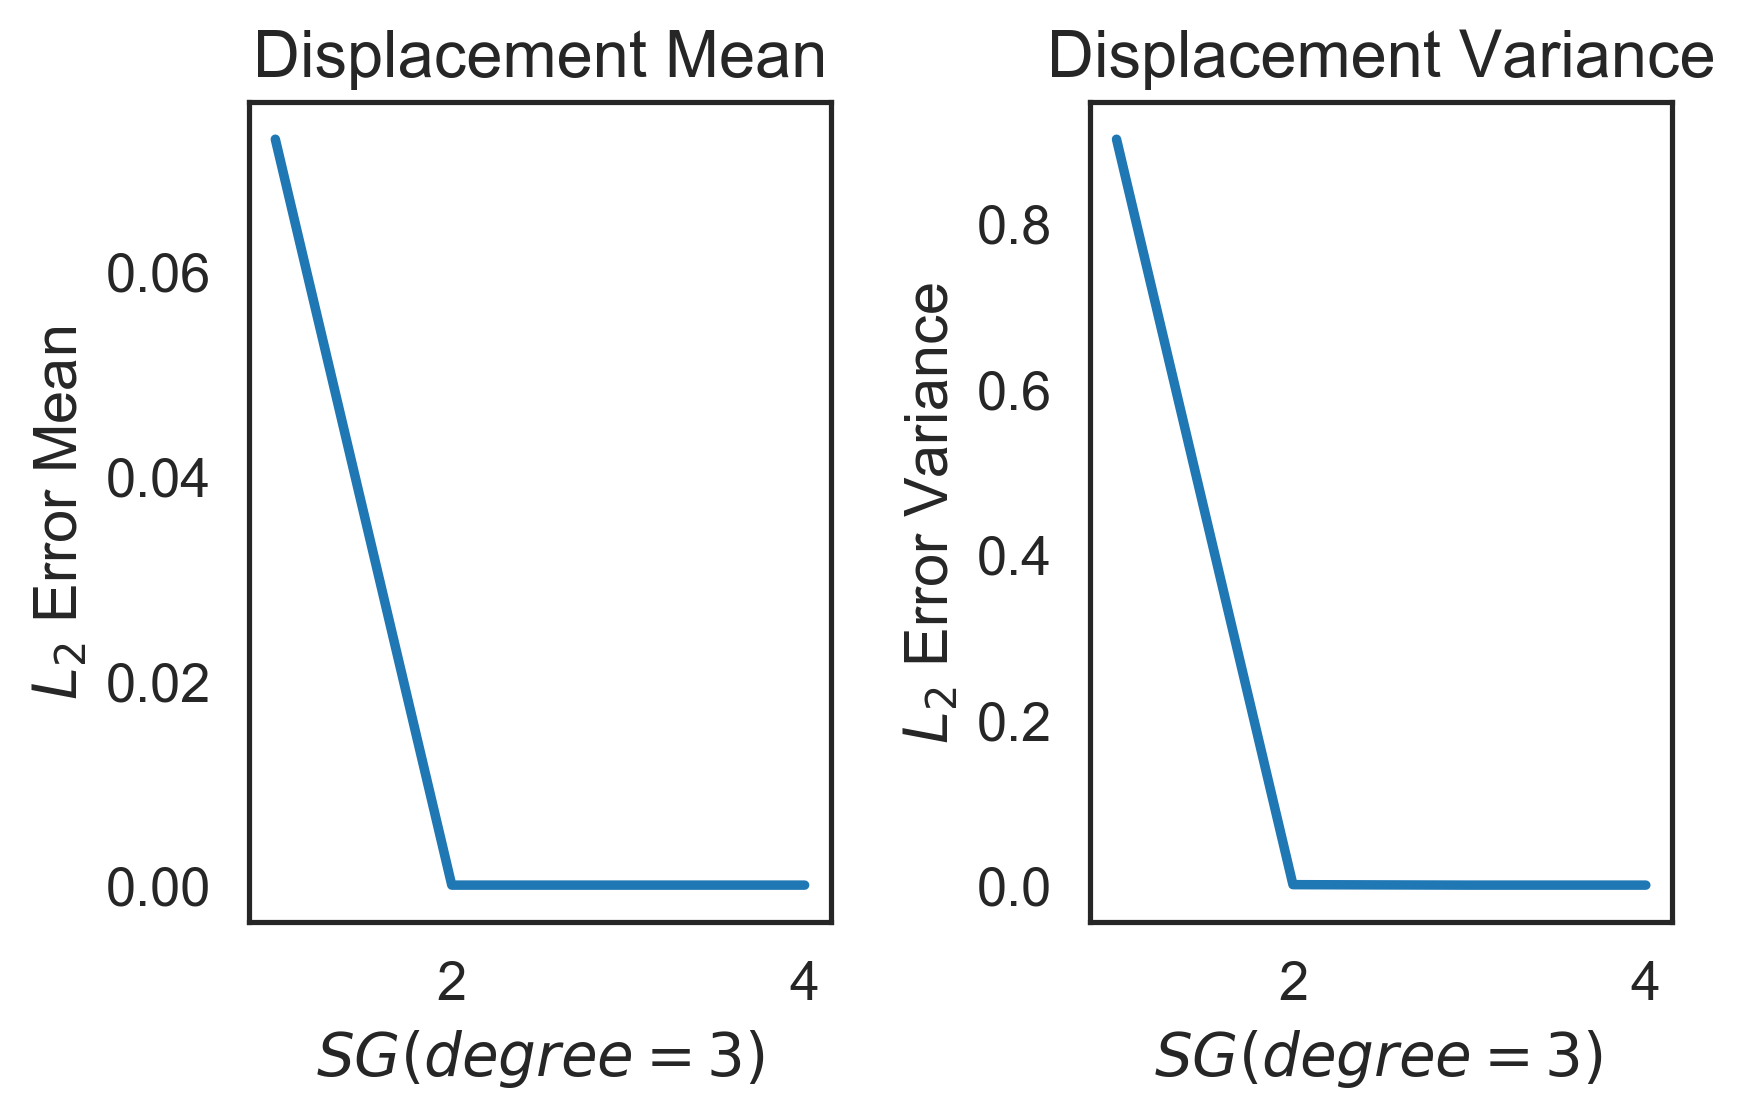

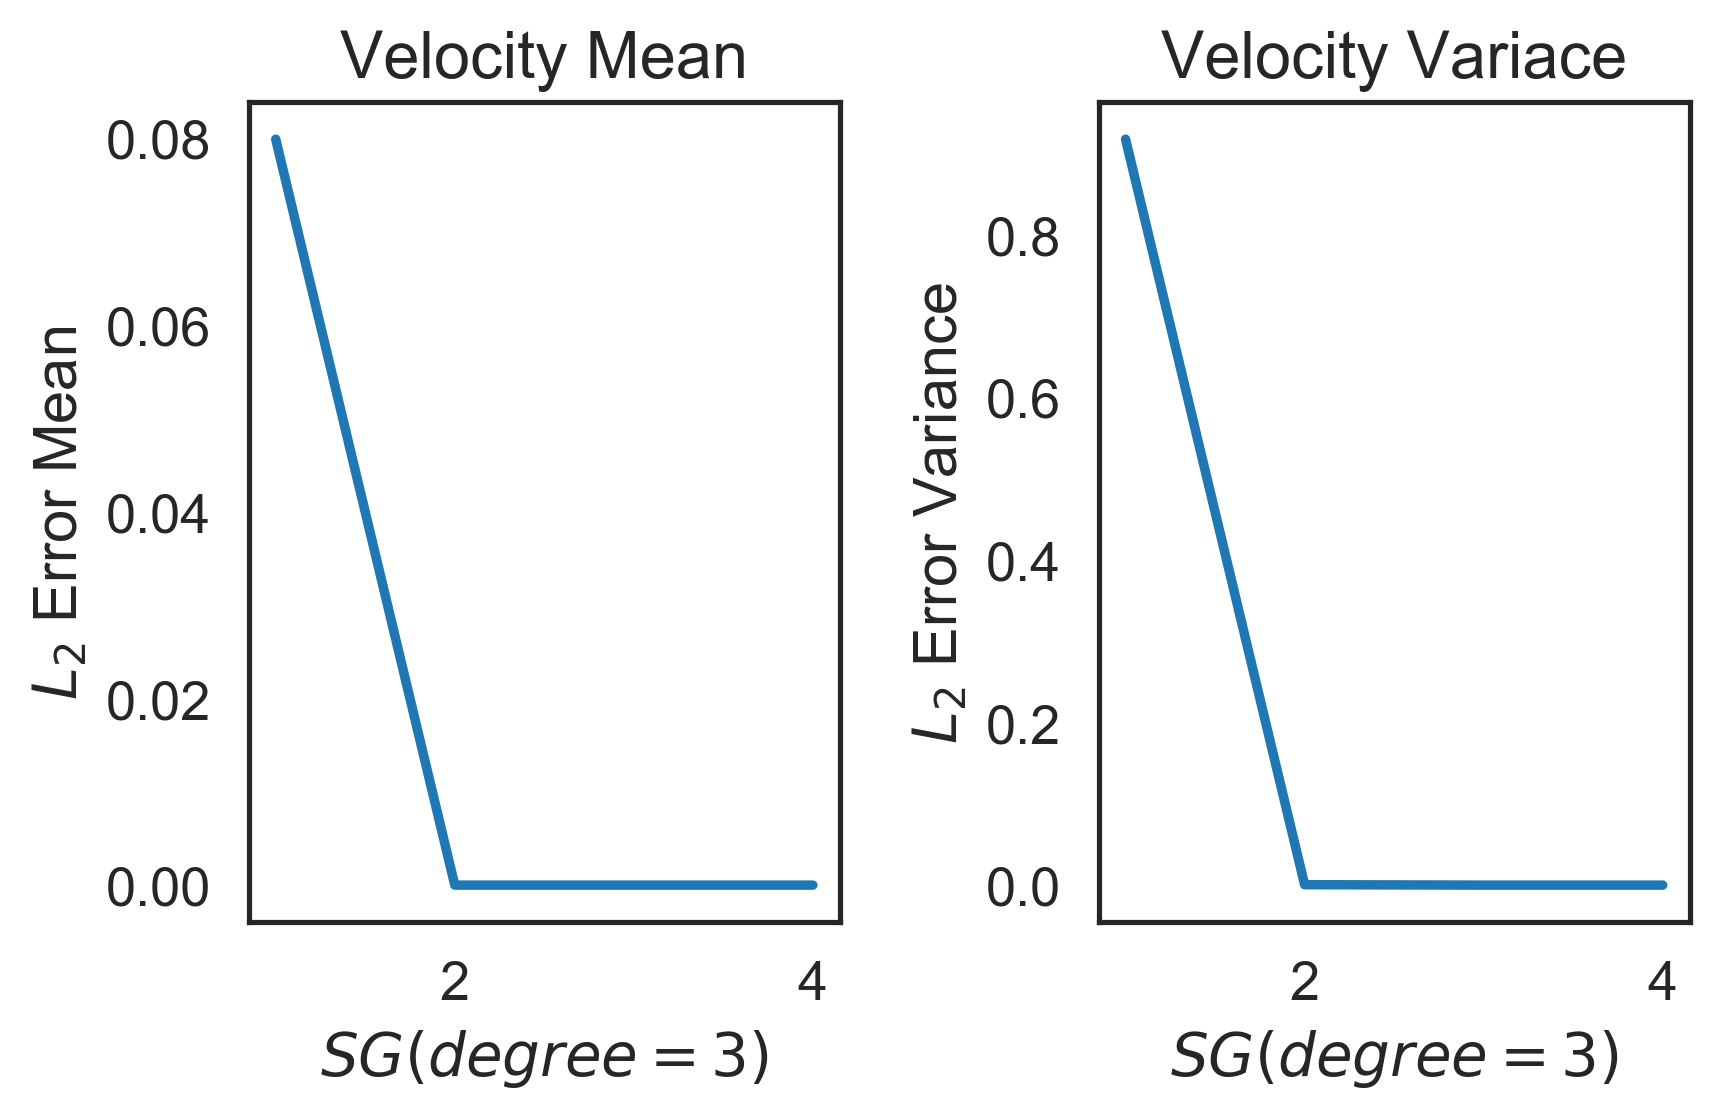

In [73]:
fig, ax = plt.subplots(1,2)
ax[0].plot(QL,L2_error_mean_y)
ax[0].set_xlabel('$SG (degree=3)$')
ax[0].set_title('Displacement Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(QL,L2_error_variance_y)
ax[1].set_xlabel('$SG (degree=3)$ ')
ax[1].set_title('Displacement Variance')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

fig, ax = plt.subplots(1,2)
ax[0].plot(QL,L2_error_mean_vel)
ax[0].set_xlabel('$SG (degree=3)$')
ax[0].set_title('Velocity Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(QL,L2_error_variance_vel)
ax[1].set_xlabel('$SG (degree=3)$')
ax[1].set_title('Velocity Variace')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

## Keeping SG level constant (=3) and chaging degree

In [68]:
rho_n=[1,2,3,4]
L2_error_mean_y=np.empty(np.size(rho_n),) 
L2_error_mean_y.fill(0) 
L2_error_variance_y=np.empty(np.size(rho_n),) 
L2_error_variance_y.fill(0) 
L2_error_mean_vel=np.empty(np.size(rho_n),) 
L2_error_mean_vel.fill(0) 
L2_error_variance_vel=np.empty(np.size(rho_n),) 
L2_error_variance_vel.fill(0) 

for i in xrange(np.size(rho_n)):
    #print i
    y1_m,y1_v,y2_m,y2_v=pc_up(rho_n[i],quad_level=3)
    L2_error_mean_y[i]=np.linalg.norm(y1_m-y_mu_lhs)/np.linalg.norm(y_mu_lhs)
    L2_error_variance_y[i]=np.linalg.norm(y1_v-y_var_lhs)/np.linalg.norm(y_var_lhs)
    
    L2_error_mean_vel[i]=np.linalg.norm(y2_m-y_vel_mu_lhs)/np.linalg.norm(y_vel_mu_lhs)
    L2_error_variance_vel[i]=np.linalg.norm(y2_v-y_vel_var_lhs)/np.linalg.norm(y_vel_var_lhs)
    


4
10
20
35


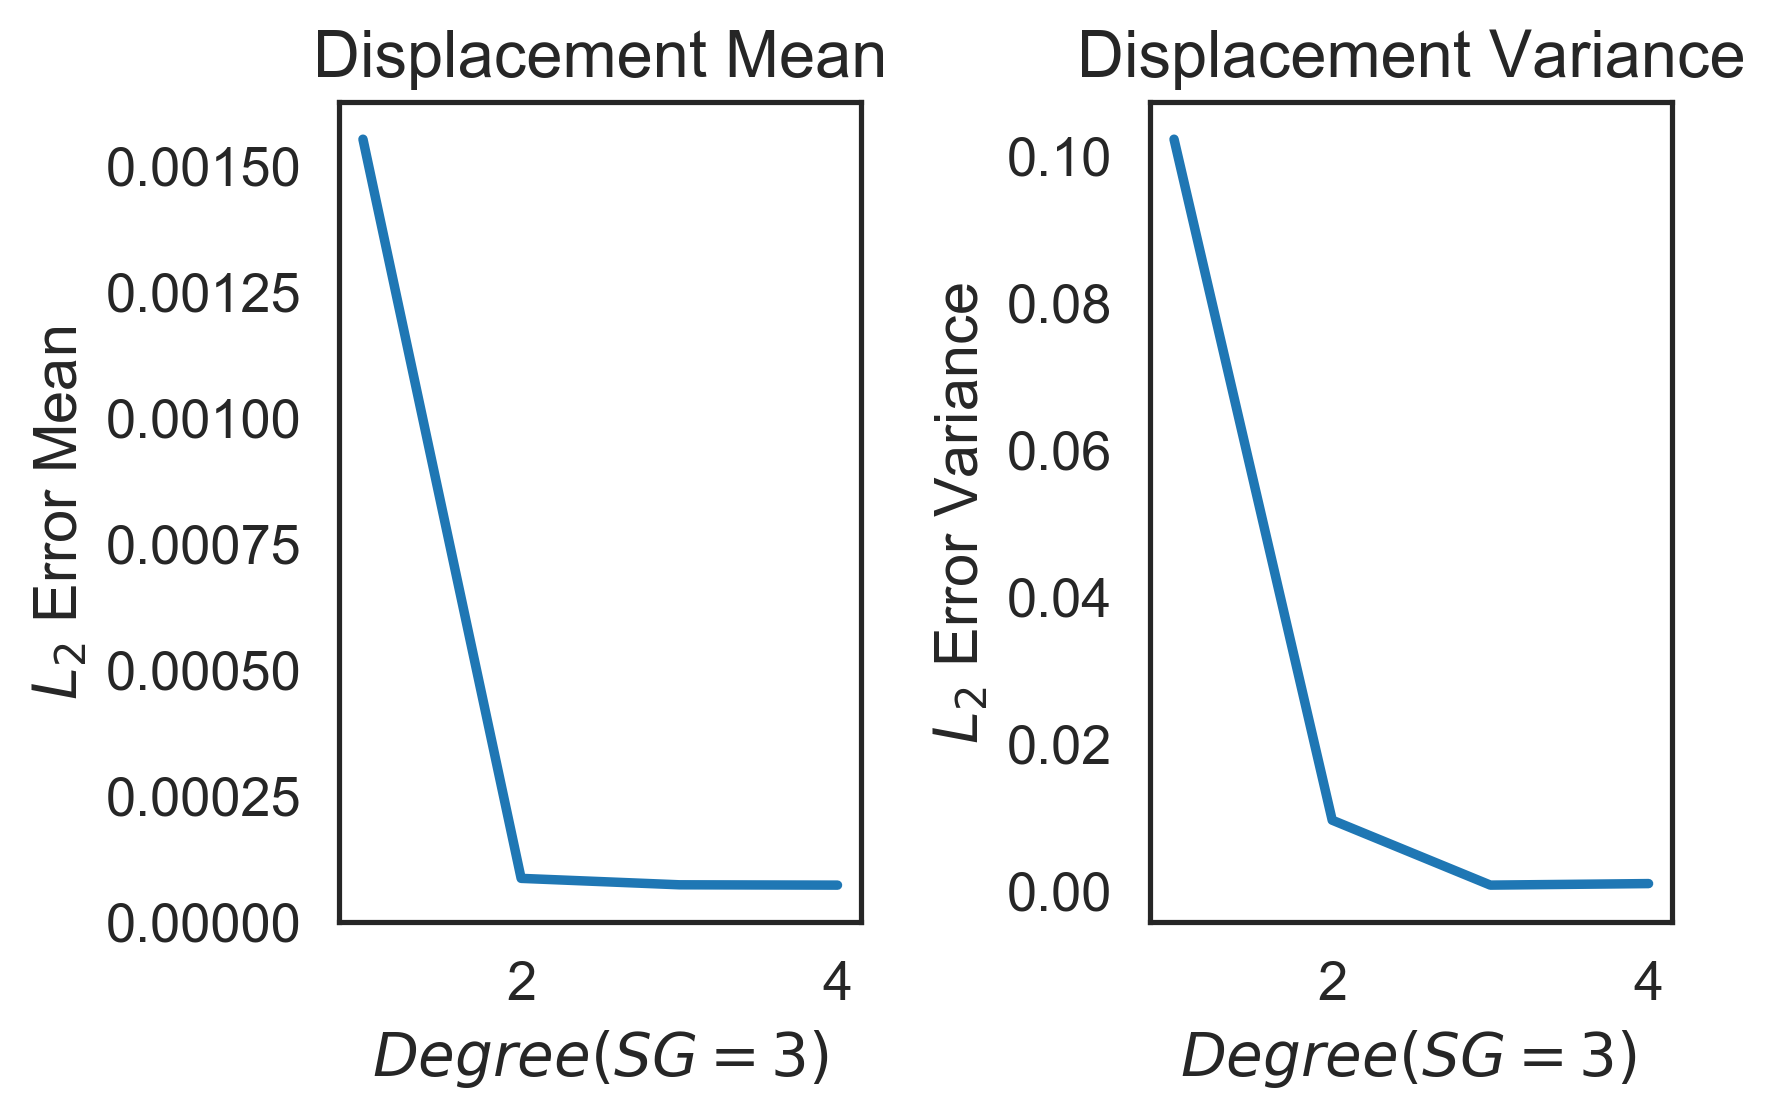

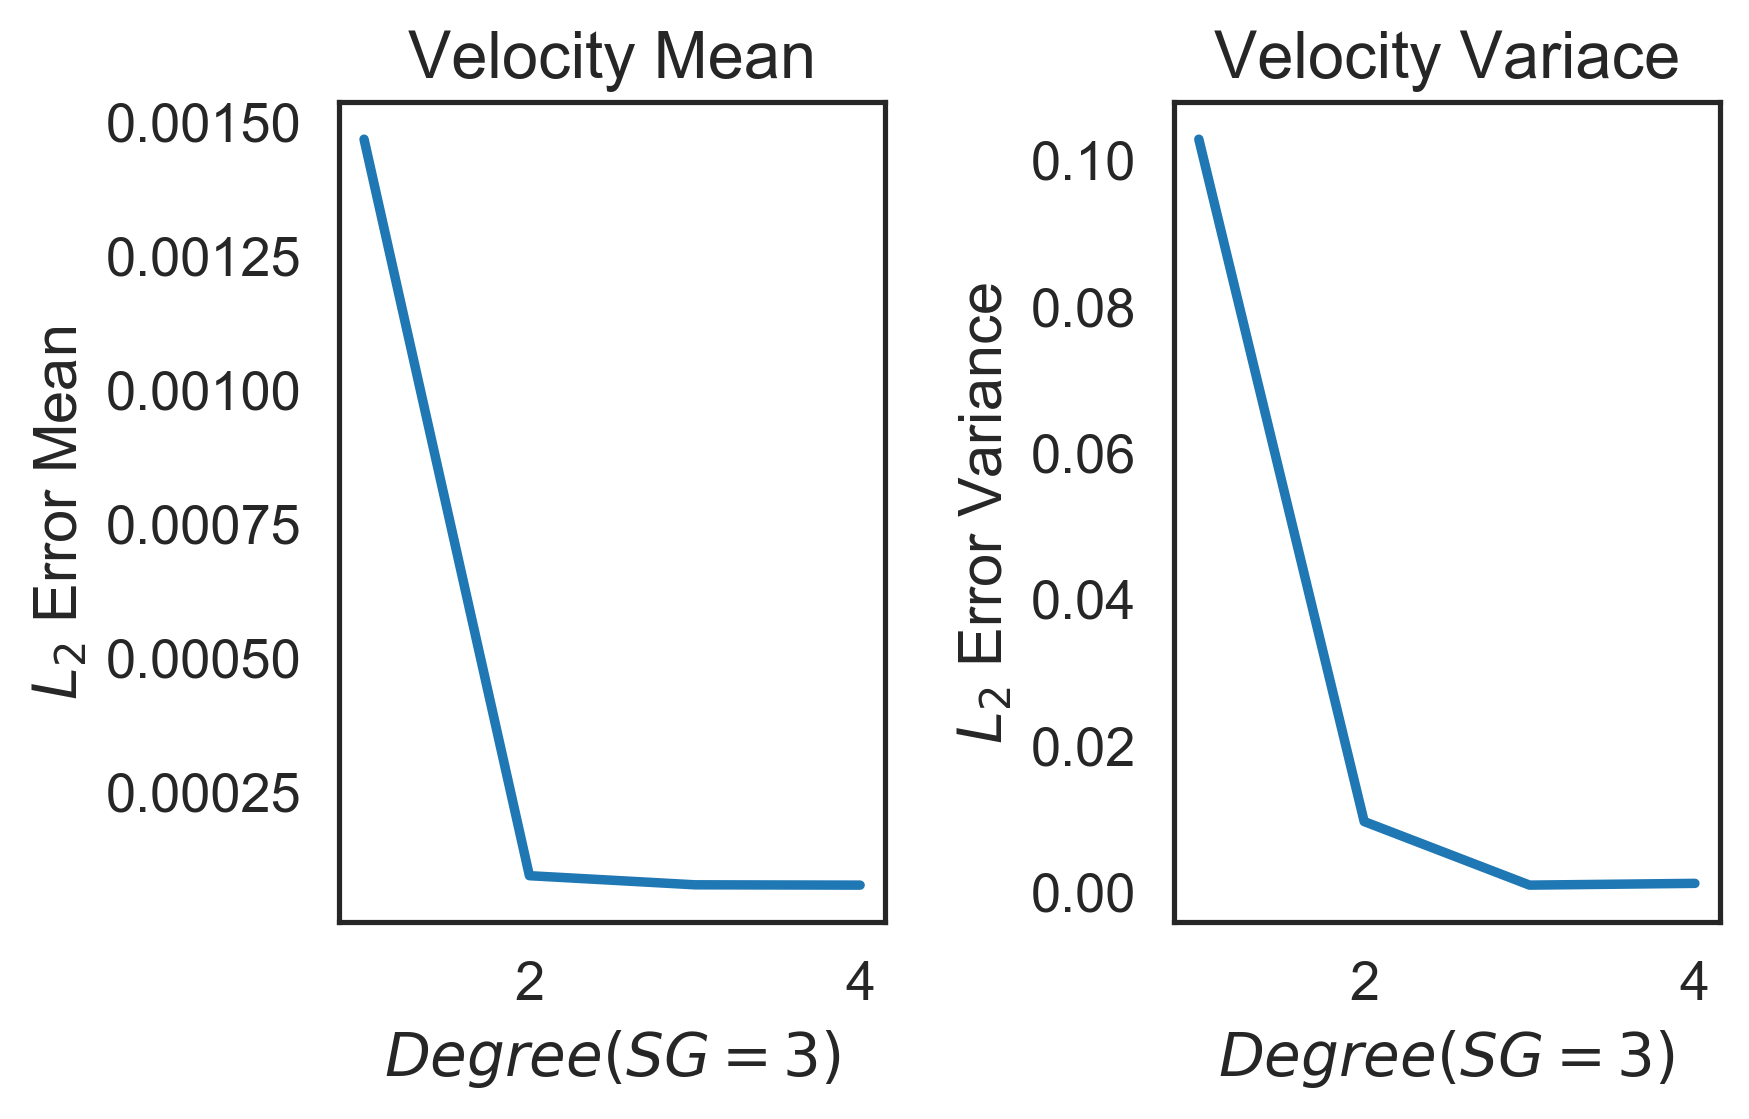

In [71]:
fig, ax = plt.subplots(1,2)
ax[0].plot(rho_n,L2_error_mean_y)
ax[0].set_xlabel('$Degree (SG=3)$')
ax[0].set_title('Displacement Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(rho_n,L2_error_variance_y)
ax[1].set_xlabel('$Degree (SG=3)$ ')
ax[1].set_title('Displacement Variance')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

fig, ax = plt.subplots(1,2)
ax[0].plot(rho_n,L2_error_mean_vel)
ax[0].set_xlabel('$Degree (SG=3)$')
ax[0].set_title('Velocity Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(rho_n,L2_error_variance_vel)
ax[1].set_xlabel('$Degree(SG=3)$')
ax[1].set_title('Velocity Variace')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

### Part (c) - Non-intrusive uncertainty propagation using stochastic collocation

Recall that the general procedure for propagating uncertainty using the stochastic collocation approach is as follows:

1. Expand the solution in a basis of polynomials that are orthonormal to the joint density of the uncertain parameters. 

2. Obtain a quadrature rule for the uncertain parameters, and compute the solution of the dynamical system at the quadrature points. 

3. Obtain the coefficients of the PCE by projecting the solution onto each basis function. 

1 - Define a function ```up_scol``` which takes as argument, the order of the polynomial expansion, $\rho$ and the level of the quadrature rule, ```max_level``` and returns the mean and variance of the displacement and velocity of the harmonic oscillator. 

In [62]:
def up_scol(rho=1, max_level=1):
    
    mu1 = 0.0; sigma1 = 1
    sX1 = st.norm()
    mu2 = 0.0; sigma2 = 1
    sX2 = st.norm()
    mu3 = 0.0; sigma3 = 1
    sX3 = st.norm()
    sX = (sX1, sX2,sX3)
    dim = len(sX)
    #mu = np.array([mu1, mu2,mu3])
    #Sigma = np.diag([sigma1 ** 2, sigma2 ** 2,sigma2 ** 3])

    degree = rho
    Phi_set = orthpol.ProductBasis((sX1, sX2,sX3), degree)
    print Phi_set.num_output
    
    # 3. We need a solver (see previous cells for the definition)
    solver =Solver(nt=100, T=5)
    
    sg_level = max_level
    Zq, v = design.sparse_grid(dim, sg_level, 'GH') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
    #w = v / 2
    #sXq = st.norm.ppf(0.5 * (Zq + 1.))
    sXq = Zq * np.sqrt(2.)
    w = v / np.sqrt(np.pi ** dim)
    
    # 4. We need a suitable quadrature rule
    #sg_level = max_level
    #Z, v = design.sparse_grid(3, sg_level, 'F1') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
    #sXq = Z * np.sqrt(2.)
    #w = v / np.sqrt(np.pi ** dim)
    #sXq = st.norm.ppf(0.5 * (Z + 1.))
    #sXq = st.expon.ppf(0.5 * (Z + 1.))
    #w = v / 2
    
    Xq = np.ndarray(sXq.shape)
    Xq[:, 0] = sXq[:, 0] * sigma1 + mu1
    Xq[:, 1] = sXq[:, 1] * sigma2 + mu2
    Xq[:, 2] = sXq[:, 2] * sigma3 + mu3
    
    # 5. Let's start the stochastic collocation approach
    C = np.zeros((solver.nt, Phi_set.num_output)) # Matrix to hold the polynomial coefficients at different times
    C_v = np.zeros((solver.nt, Phi_set.num_output)) # Matrix to hold the polynomial coefficients at different times
    for i in range(Xq.shape[0]):
        phi_i = Phi_set(sXq[i, :][None, :])
        y_i = solver(Xq[i])[:, 0]
        C += w[i] * y_i[:, None] * phi_i
        
        v_i = solver(Xq[i])[:, 1]
        C_v += w[i] * v_i[:, None] * phi_i
        
    print 'I did %d solver evaluations!' % Xq.shape[0]
    
    # 6. Extract the statistics
    y_pc_col_m = C[:, 0]
    y_pc_col_v = np.sum(C[:, 1:] ** 2, axis=1)
    #t = np.linspace(0, 100, 500)   #get timesteps 
    v_pc_col_m = C_v[:, 0]
    v_pc_col_v = np.sum(C_v[:, 1:] ** 2, axis=1)
    
    return y_pc_col_m,y_pc_col_v,v_pc_col_m,v_pc_col_v

In [63]:
rho=3
max_level=5
y_pc_col_m,y_pc_col_v,v_pc_col_m,v_pc_col_v=up_scol(rho, max_level)

20
I did 2031 solver evaluations!


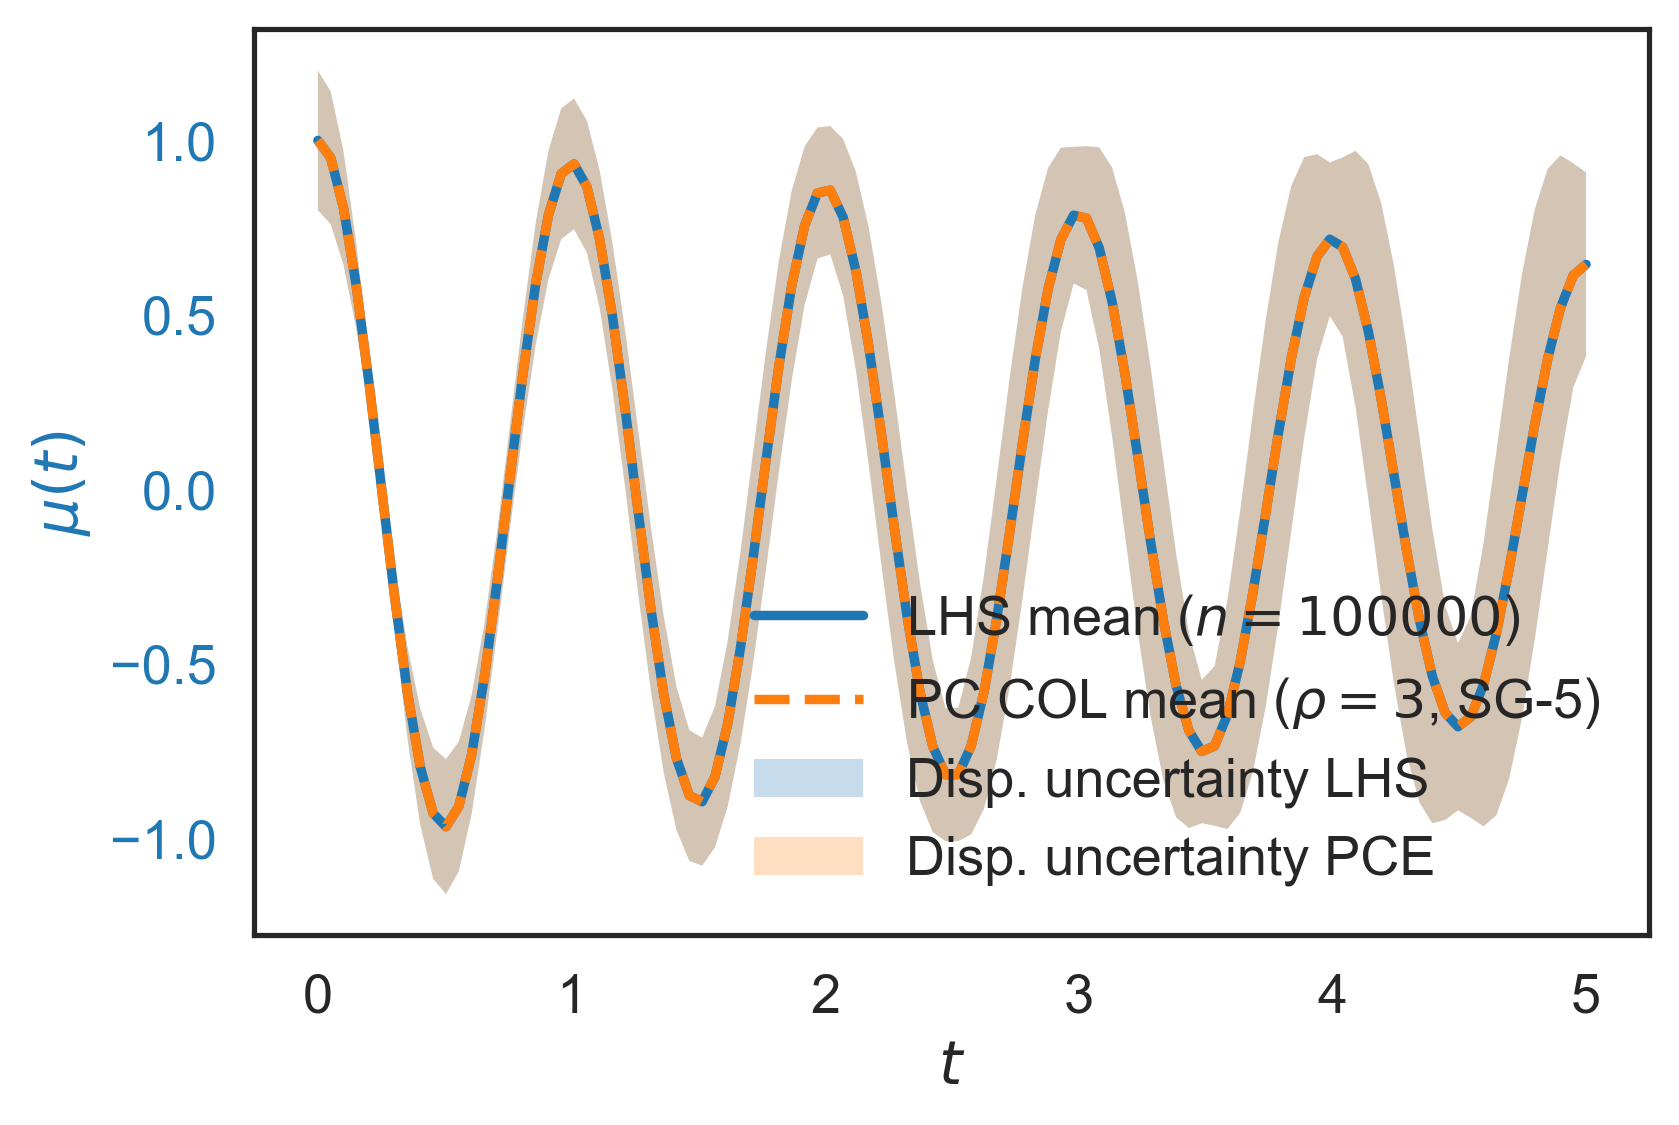

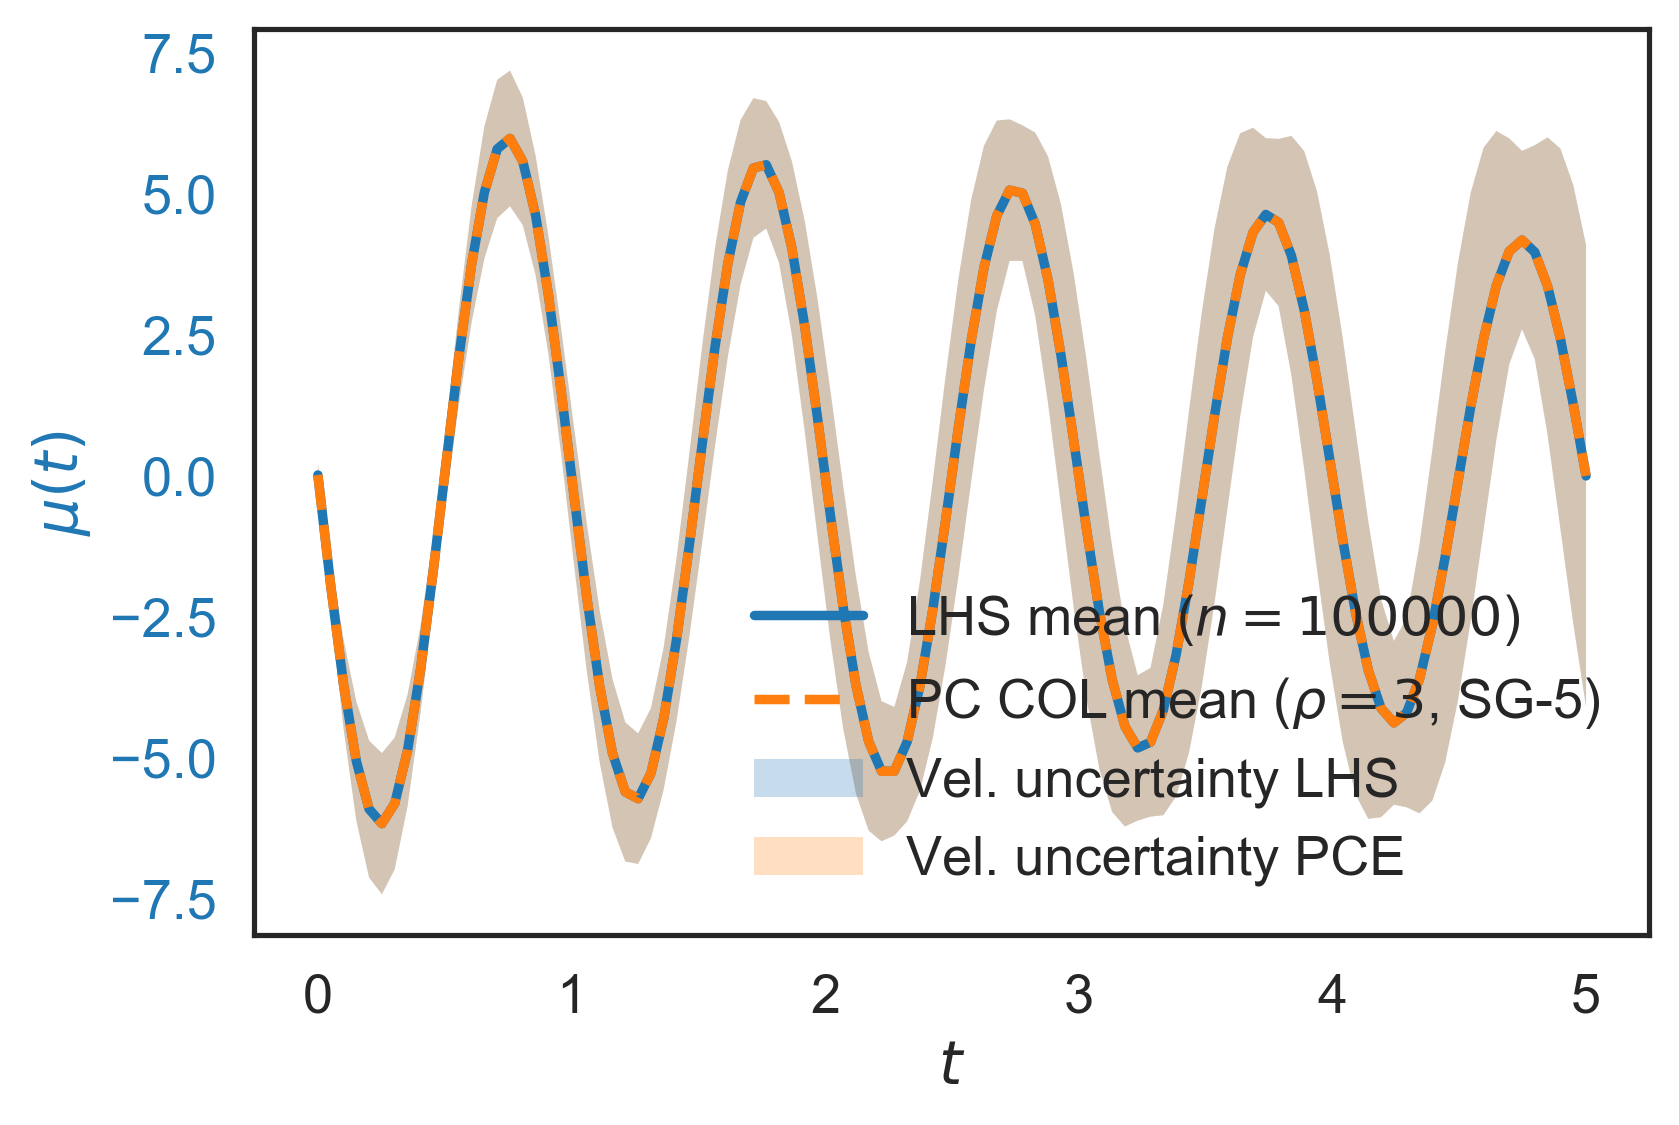

In [64]:
# Make the figure
fig1, ax1 = plt.subplots()
y_std_lhs=np.sqrt(y_var_lhs)
y_std_pce=np.sqrt(y_pc_col_v)
# Plot the mean and compare to LHS
ax1.plot(solver.t, y_mu_lhs, color=sns.color_palette()[0], label='LHS mean ($n=%d$)' % num_lhs)
ax1.plot(t, y_pc_col_m, '--', color=sns.color_palette()[1], label=r'PC COL mean ($\rho=%d$, SG-%d)' % (rho, max_level))
plt.fill_between(solver.t, y_mu_lhs-2*y_std_lhs, y_mu_lhs+2*y_std_lhs, alpha=0.25, label = 'Disp. uncertainty LHS')
plt.fill_between(t, y_pc_col_m-2*y_std_pce,y_pc_col_m+2*y_std_pce, alpha=0.25, label = 'Disp. uncertainty PCE')

ax1.set_xlabel('$t$')
ax1.set_ylabel('$\mu(t)$', color=sns.color_palette()[0])
ax1.tick_params('y', colors=sns.color_palette()[0])
plt.legend(loc='best')
#
## Plot variance and compare to LHS
#ax2 = ax1.twinx()
#ax2.plot(solver.t, y_var_lhs, color=sns.color_palette()[2], label='LHS variance ($n=%d$)' % (num_lhs))
#ax2.plot(solver.t, y_pc_col_v, '--', color=sns.color_palette()[3], label=r'PC COL variance ($\rho=%d$, SG-%d$)' % (rho, max_level))
#ax2.set_ylabel('$\sigma^2(t) = k(t, t)$', color=sns.color_palette()[2])
#ax2.tick_params('y', colors=sns.color_palette()[2])
#plt.legend(loc='best');
#
## Make the figure

fig1, ax1 = plt.subplots()
y_vel_std_lhs=np.sqrt( y_vel_var_lhs)
v_std_pce=np.sqrt(v_pc_col_v)

# Plot the mean and compare to LHS
ax1.plot(solver.t, y_vel_mu_lhs, color=sns.color_palette()[0], label='LHS mean ($n=%d$)' % num_lhs)
ax1.plot(t, v_pc_col_m, '--', color=sns.color_palette()[1], label=r'PC COL mean ($\rho=%d$, SG-%d)' % (rho, max_level))
plt.fill_between(solver.t, y_vel_mu_lhs-2*y_vel_std_lhs, y_vel_mu_lhs+2*y_vel_std_lhs, alpha=0.25, label = 'Vel. uncertainty LHS')
plt.fill_between(t, v_pc_col_m-2*v_std_pce,v_pc_col_m+2*v_std_pce, alpha=0.25, label = 'Vel. uncertainty PCE')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\mu(t)$', color=sns.color_palette()[0])
ax1.tick_params('y', colors=sns.color_palette()[0])
plt.legend(loc='best')

# Plot variance and compare to LHS
#ax2 = ax1.twinx()
#ax2.plot(solver.t, y_vel_var_lhs, color=sns.color_palette()[2], label='LHS variance ($n=%d$)' % (num_lhs))
#ax2.plot(solver.t, v_pc_col_v, '--', color=sns.color_palette()[3], label=r'PC COL variance ($\rho=%d$, SG-%d)' % (rho, max_level))
#ax2.set_ylabel('$\sigma^2(t) = k(t, t)$', color=sns.color_palette()[2])
#ax2.tick_params('y', colors=sns.color_palette()[2])
#plt.legend(loc='best');

2 - Just like the previous question, do a convergence study of the stochastic collocation approach, by varying the order of the polynomial basis and the level of the quadrature rule. As usual, use the relative error as your error metric.

## Keeping degree constant (=3) and chaging SG level

In [76]:
QL=[1,2,3,5];
rho_n=[3,3,3,3]
L2_error_mean_y=np.empty(np.size(rho_n),) 
L2_error_mean_y.fill(0) 
L2_error_variance_y=np.empty(np.size(rho_n),) 
L2_error_variance_y.fill(0) 
L2_error_mean_vel=np.empty(np.size(rho_n),) 
L2_error_mean_vel.fill(0) 
L2_error_variance_vel=np.empty(np.size(rho_n),) 
L2_error_variance_vel.fill(0) 

for i in xrange(np.size(rho_n)):
    #print i
    y_pc_col_m,y_pc_col_v,v_pc_col_m,v_pc_col_v=up_scol(rho_n[i],QL[i])
    L2_error_mean_y[i]=np.linalg.norm(y_pc_col_m-y_mu_lhs)/np.linalg.norm(y_mu_lhs)
    L2_error_variance_y[i]=np.linalg.norm(y_pc_col_v-y_var_lhs)/np.linalg.norm(y_var_lhs)
    
    L2_error_mean_vel[i]=np.linalg.norm(v_pc_col_m-y_vel_mu_lhs)/np.linalg.norm(y_vel_mu_lhs)
    L2_error_variance_vel[i]=np.linalg.norm(v_pc_col_v-y_vel_var_lhs)/np.linalg.norm(y_vel_var_lhs)
    

    

20
I did 7 solver evaluations!
20
I did 37 solver evaluations!
20
I did 159 solver evaluations!
20
I did 2031 solver evaluations!


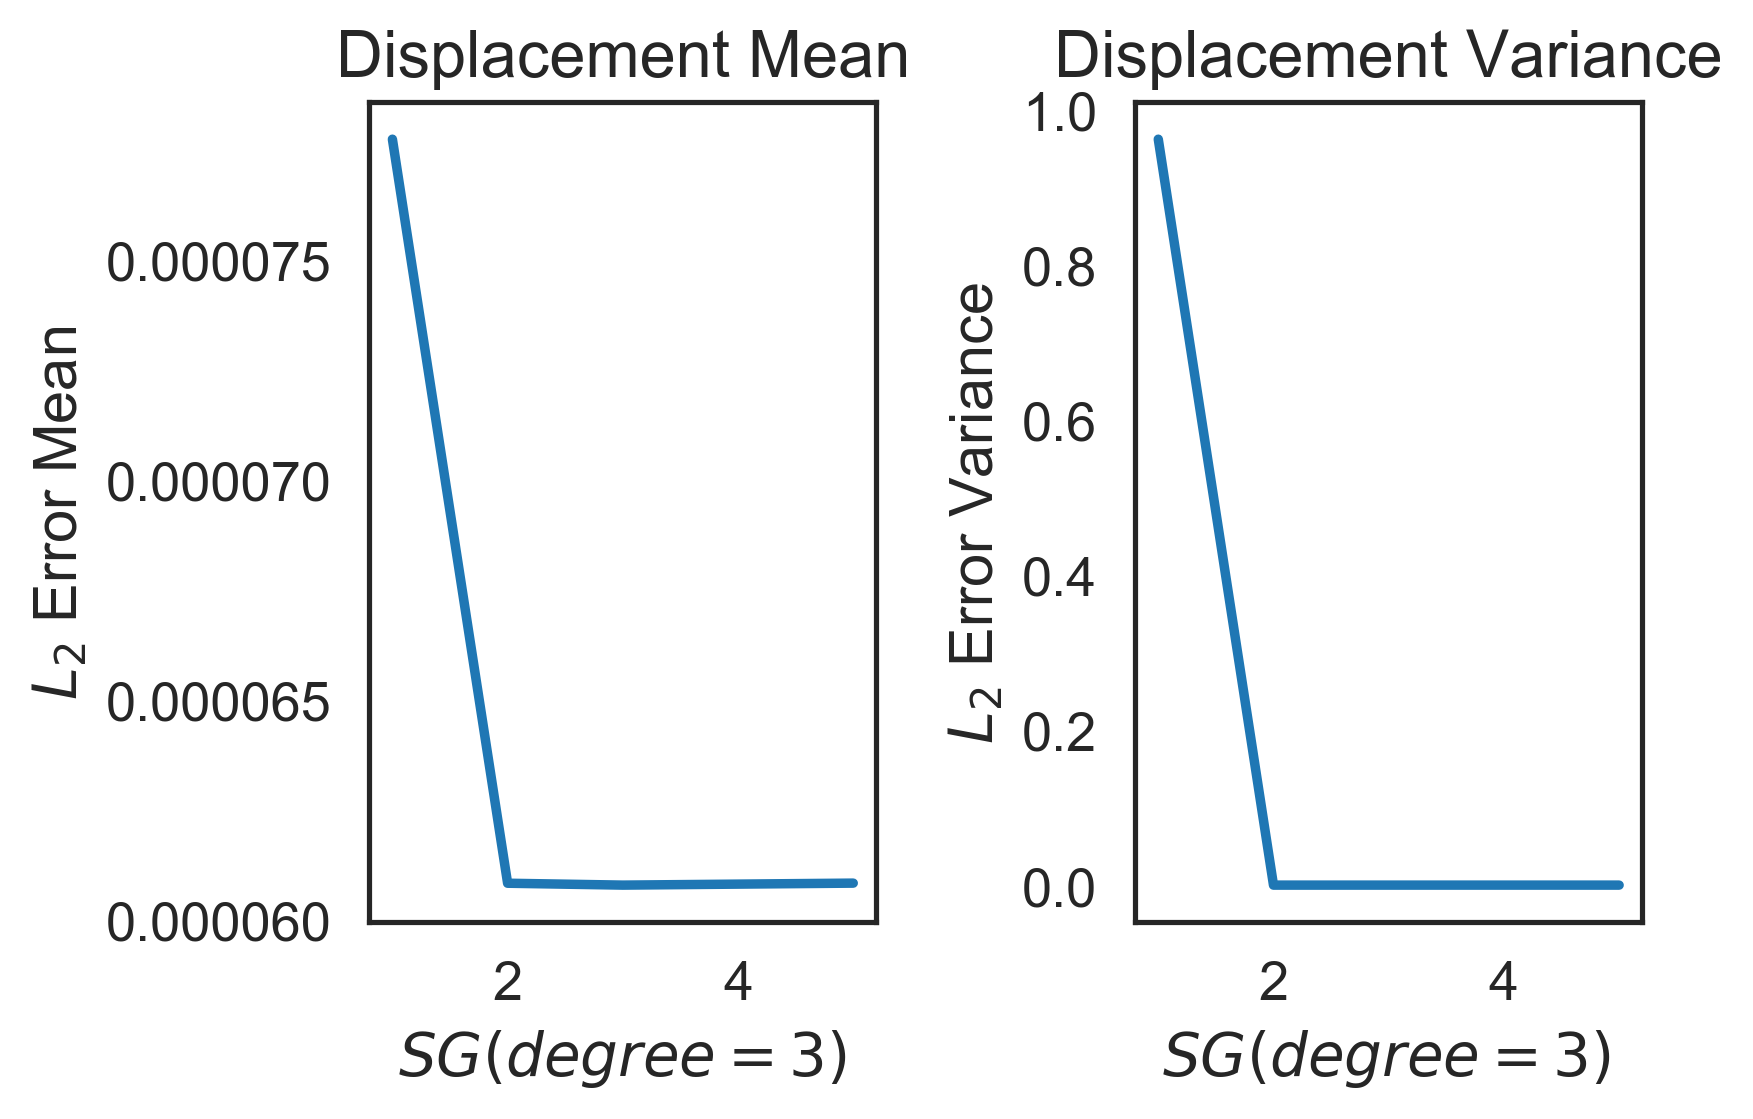

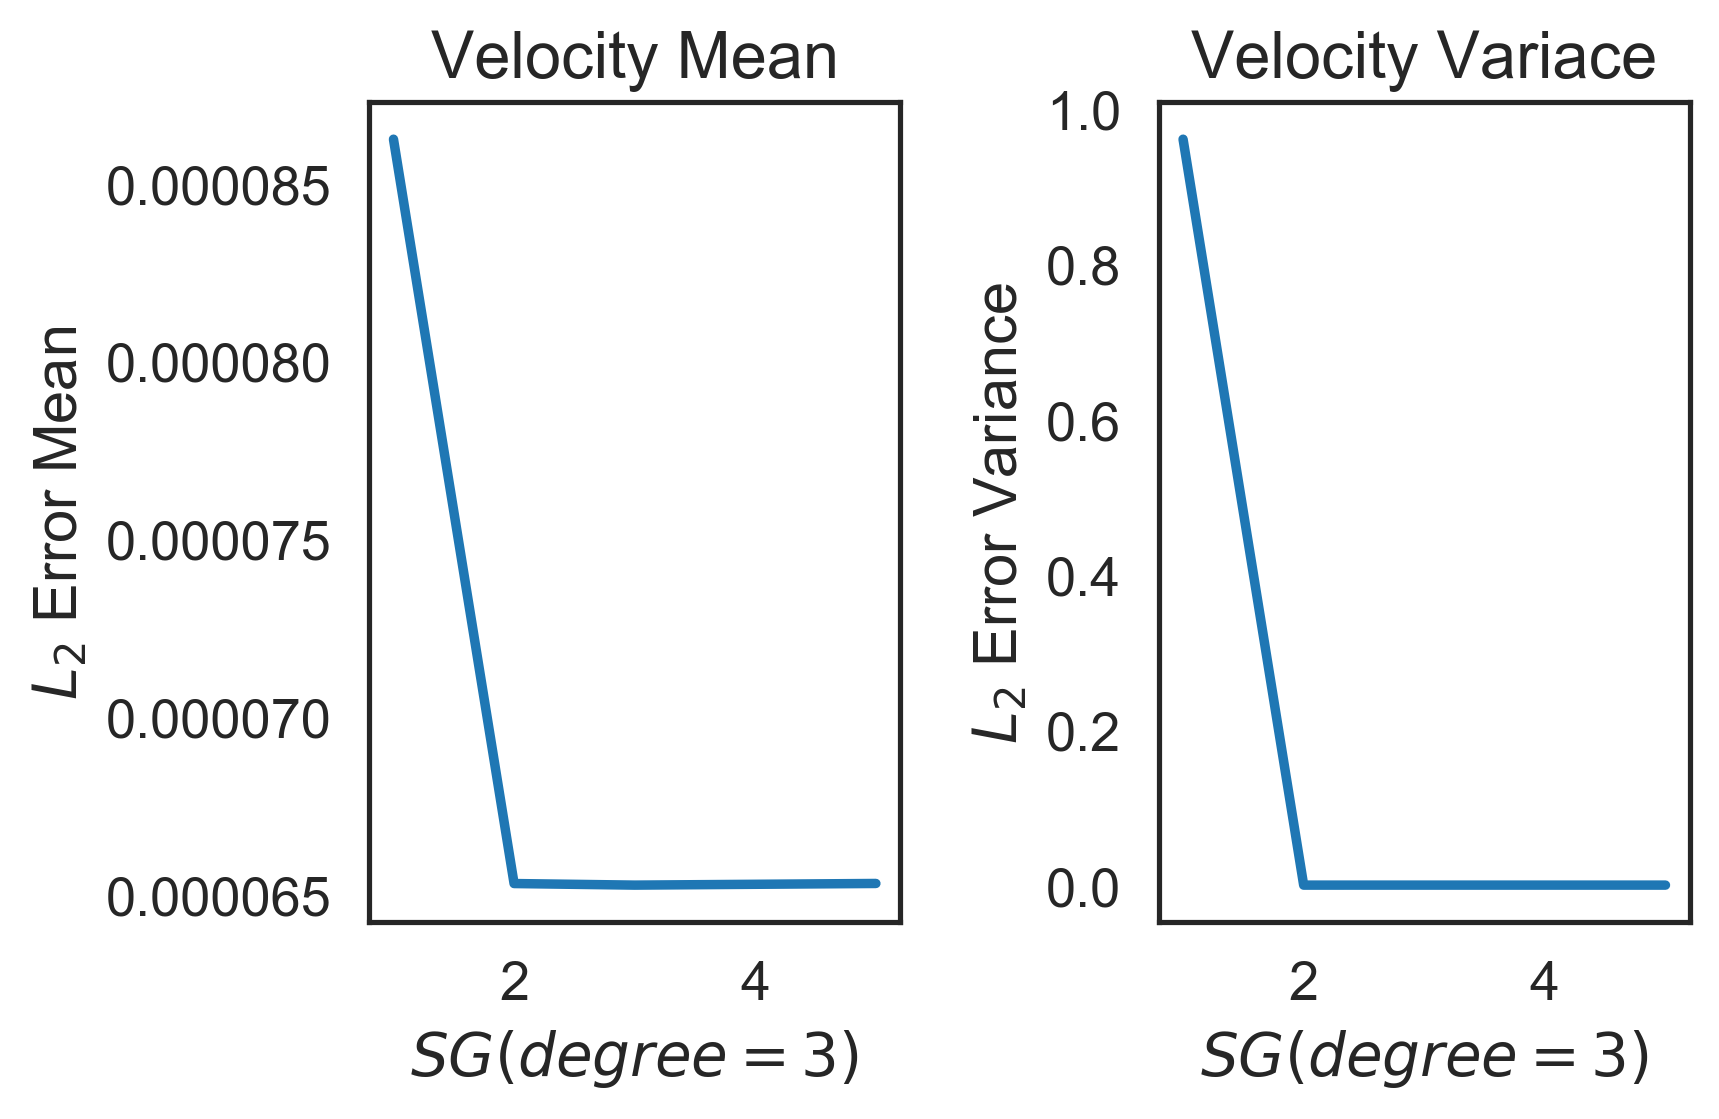

In [77]:
fig, ax = plt.subplots(1,2)
ax[0].plot(QL,L2_error_mean_y)
ax[0].set_xlabel('$SG (degree=3)$')
ax[0].set_title('Displacement Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(QL,L2_error_variance_y)
ax[1].set_xlabel('$SG (degree=3)$ ')
ax[1].set_title('Displacement Variance')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

fig, ax = plt.subplots(1,2)
ax[0].plot(QL,L2_error_mean_vel)
ax[0].set_xlabel('$SG (degree=3)$')
ax[0].set_title('Velocity Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(QL,L2_error_variance_vel)
ax[1].set_xlabel('$SG (degree=3)$')
ax[1].set_title('Velocity Variace')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

## Keeping SG level constant (=5) and chaging degree

In [74]:
rho_n=[1,2,3,4]
L2_error_mean_y=np.empty(np.size(rho_n),) 
L2_error_mean_y.fill(0) 
L2_error_variance_y=np.empty(np.size(rho_n),) 
L2_error_variance_y.fill(0) 
L2_error_mean_vel=np.empty(np.size(rho_n),) 
L2_error_mean_vel.fill(0) 
L2_error_variance_vel=np.empty(np.size(rho_n),) 
L2_error_variance_vel.fill(0) 

for i in xrange(np.size(rho_n)):
    #print i
    y_pc_col_m,y_pc_col_v,v_pc_col_m,v_pc_col_v=up_scol(rho_n[i],max_level=5)
    L2_error_mean_y[i]=np.linalg.norm(y_pc_col_m-y_mu_lhs)/np.linalg.norm(y_mu_lhs)
    L2_error_variance_y[i]=np.linalg.norm(y_pc_col_v-y_var_lhs)/np.linalg.norm(y_var_lhs)
    
    L2_error_mean_vel[i]=np.linalg.norm(v_pc_col_m-y_vel_mu_lhs)/np.linalg.norm(y_vel_mu_lhs)
    L2_error_variance_vel[i]=np.linalg.norm(v_pc_col_v-y_vel_var_lhs)/np.linalg.norm(y_vel_var_lhs)
    


4
I did 2031 solver evaluations!
10
I did 2031 solver evaluations!
20
I did 2031 solver evaluations!
35
I did 2031 solver evaluations!


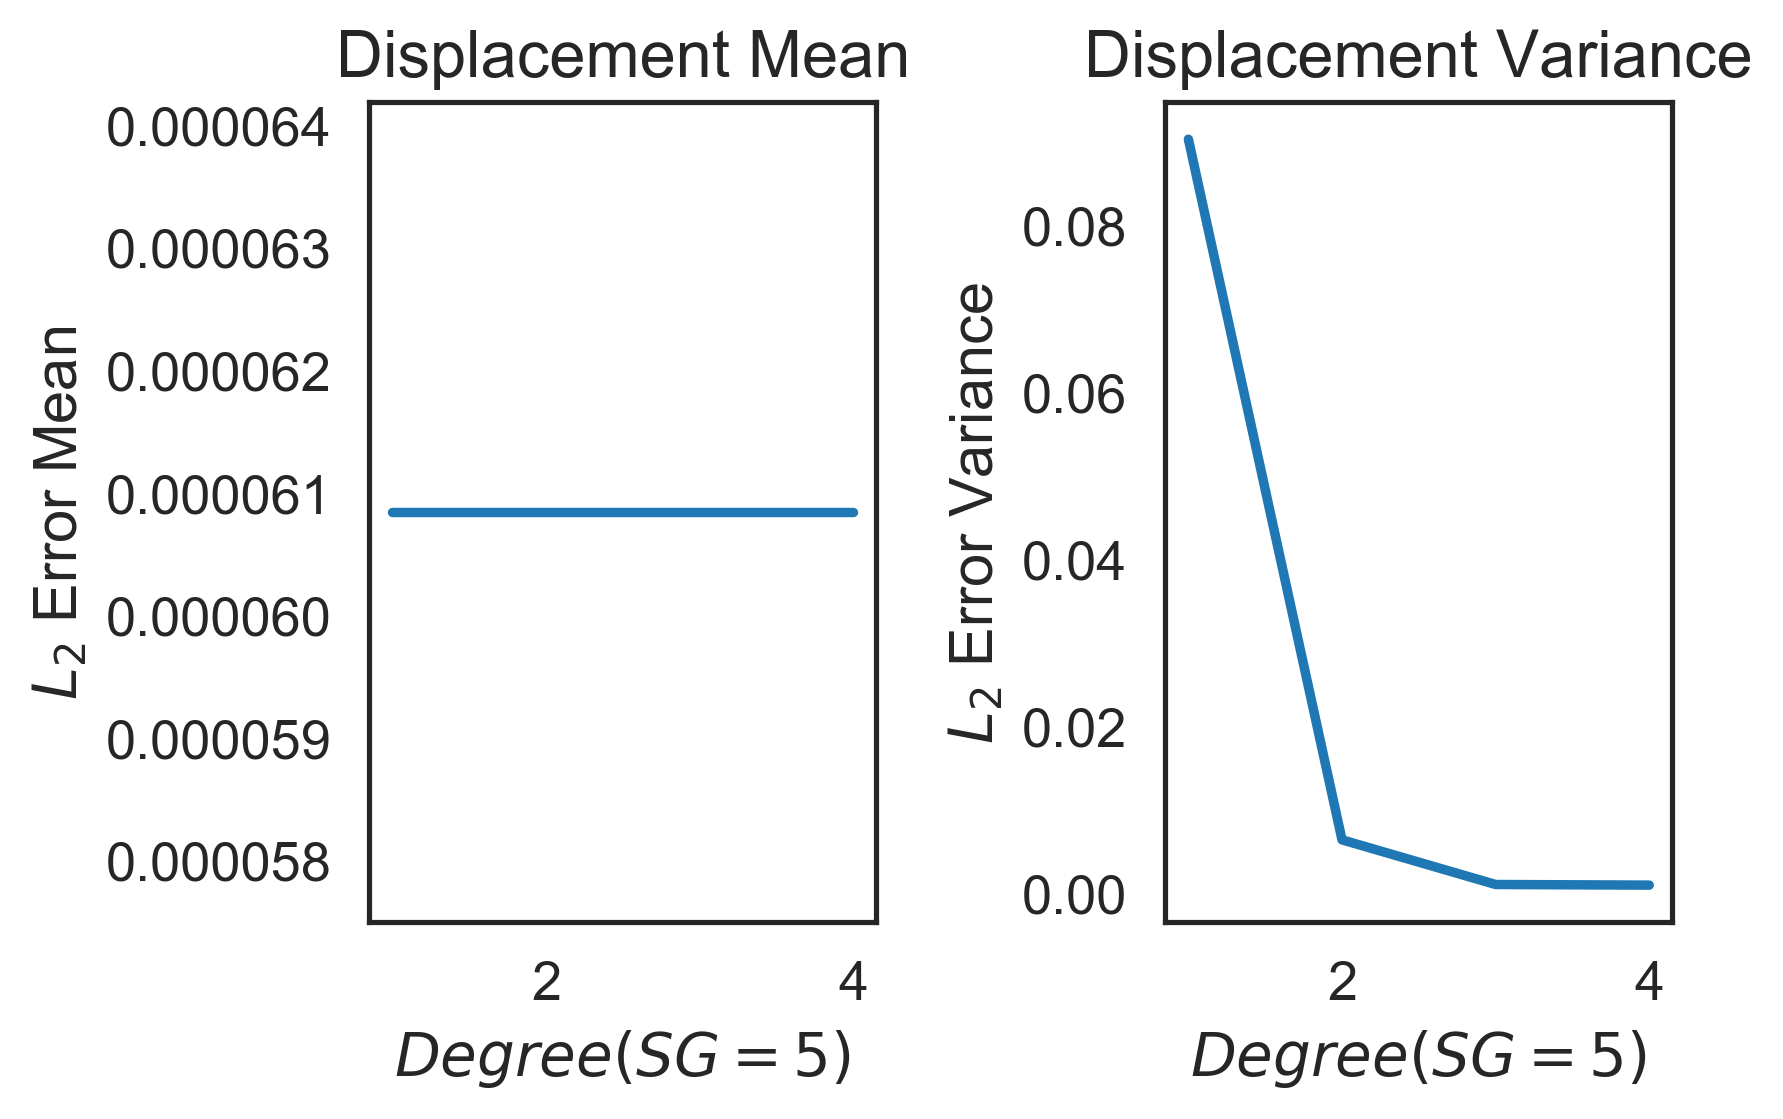

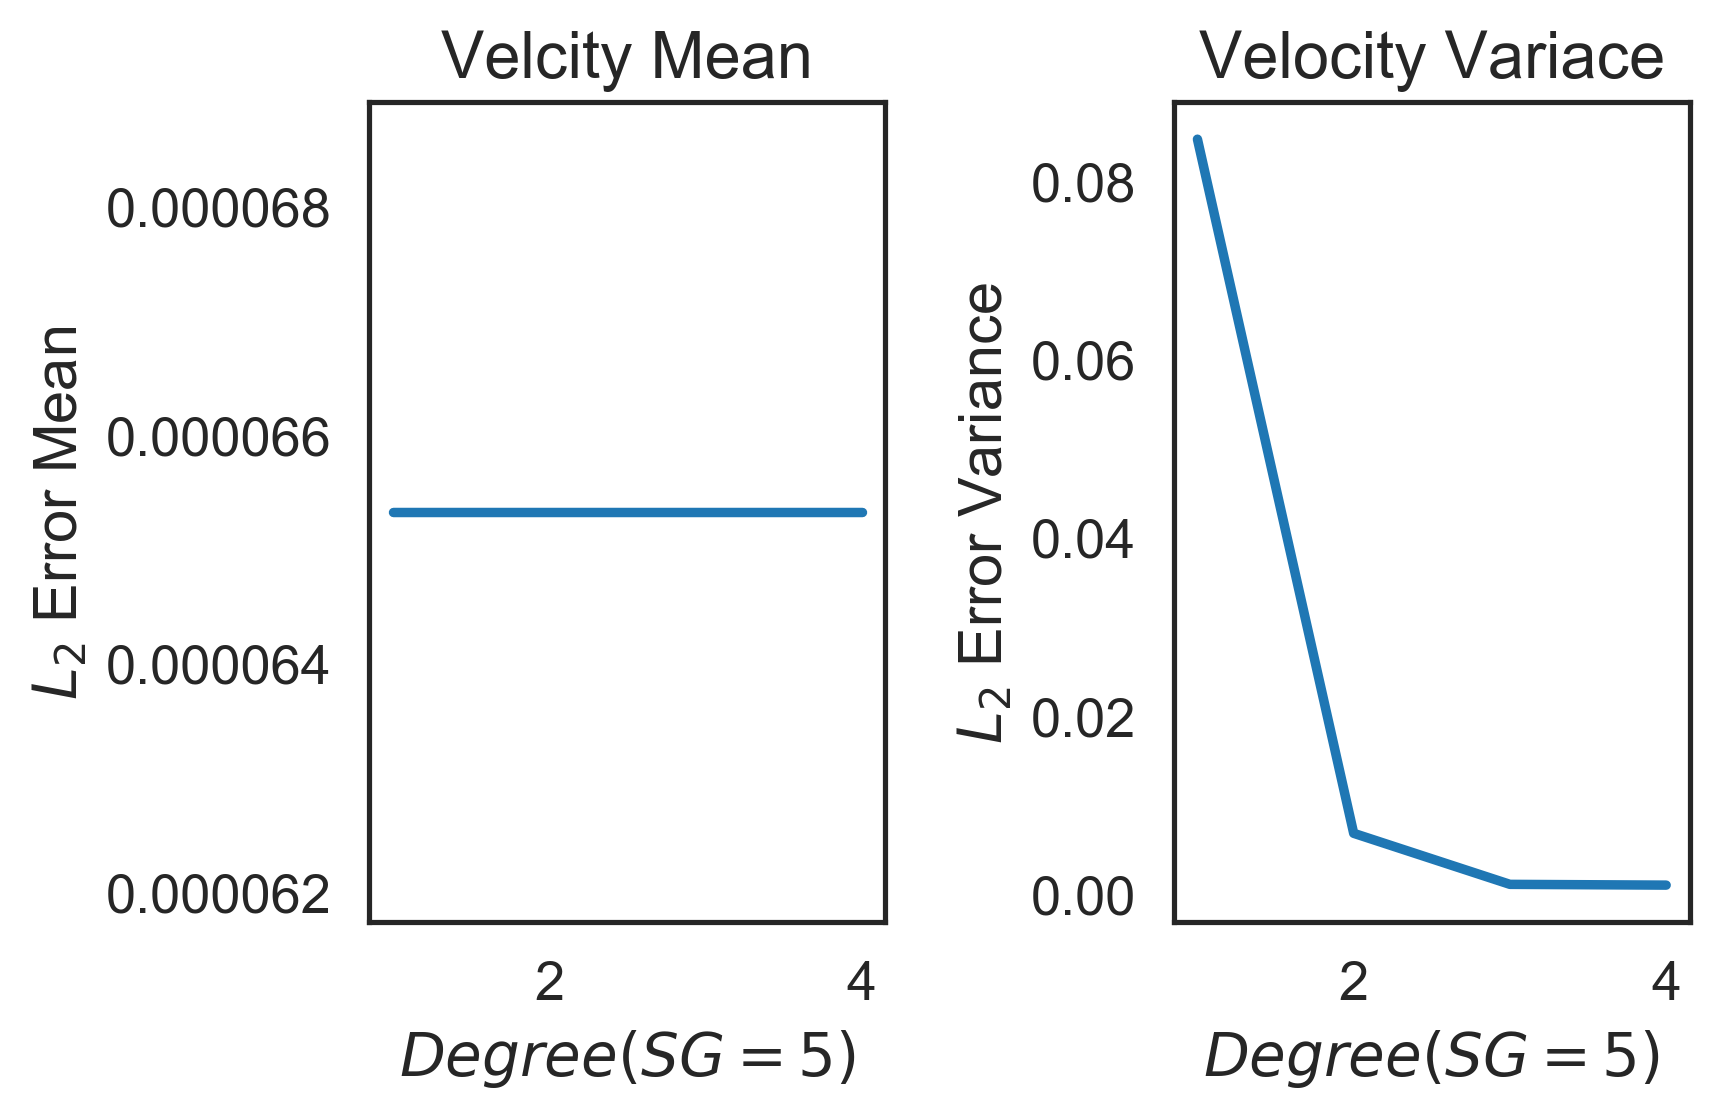

In [75]:
fig, ax = plt.subplots(1,2)
ax[0].plot(rho_n,L2_error_mean_y)
ax[0].set_xlabel('$Degree (SG=5)$')
ax[0].set_title('Displacement Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(rho_n,L2_error_variance_y)
ax[1].set_xlabel('$Degree (SG=5)$')
ax[1].set_title('Displacement Variance')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

fig, ax = plt.subplots(1,2)
ax[0].plot(rho_n,L2_error_mean_vel)
ax[0].set_xlabel('$Degree (SG=5)$')
ax[0].set_title('Velcity Mean')
ax[0].set_ylabel('$L_2$ Error Mean')

ax[1].plot(rho_n,L2_error_variance_vel)
ax[1].set_xlabel('$Degree (SG=5)$')
ax[1].set_title('Velocity Variace')
ax[1].set_ylabel('$L_2$ Error Variance')
plt.tight_layout()

*Enter solution/code here. *
<br><br><br><br><br><br><br><br><br><br>